# Comparison of colon subtype association networks with DRAGON

In this notebook we are reproducing the colon cancer subtype results of the "Reproducible processing of TCGA regulatory
networks" paper.

After generating DRAGON networks for the four major consensus subtypes (CMS1 to CMS4) we proceed to analyze these
networks. We are interested in investigating whether complex multi-omics associations can explain the different
phenotypes of the four groups, and in particular the worse prognostics of CMS4.

First we are going to import some packages and define some functions. Go to section [Read the data](#read-the-data).

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
import scipy.stats as stats
import gseapy as gp
import networkx as nx

# this is necessary only for better label positioning
!pip install adjustText

In [3]:
def draw_both_graphs(G, fig_name):
    """Draw both graphs for CMS2 and CMS4
    pass a graph G and the figure name (pass relative path as well)
    """
    
    pos = nx.spring_layout(G, seed=100, iterations=35, k =  1/np.sqrt(len(G.nodes)))  # positions for all nodes
    #pos = nx.spectral_layout(G, scale=.1, center=None, dim=2)
    weights2 = nx.get_edge_attributes(G,'cms2').values()
    weights4 = nx.get_edge_attributes(G,'cms4').values()
    edge_labels = nx.get_edge_attributes(G,'edge_label_oi').values()
    edge_width = list(nx.get_edge_attributes(G,'edge_label_width').values())

    f,ax = plt.subplots(1,2,figsize = (15,10))
    options_node = {"node_size": 100, "alpha": 0.5}

    node_meth = [i  for i in list(G.nodes) if i.endswith('methylation') ]
    node_expr = [i  for i in list(G.nodes) if i.endswith('expression') ]

    # Methylation and expression nodes for CMS2
    nx.draw_networkx_nodes(G, pos, nodelist=node_meth, node_color="#66c2a5", **options_node, ax = ax[0])#, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=node_expr, node_color="#fc8d62", **options_node, ax = ax[0])#, edgecolors='k')
    
    # Methylation and expression nodes for CMS4
    nx.draw_networkx_nodes(G, pos, nodelist=node_meth, node_color="#66c2a5", **options_node, ax = ax[1])#, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=node_expr, node_color="#fc8d62", **options_node, ax = ax[1])#, edgecolors='k')

    # Node labels for methylation
    nx.draw_networkx_labels(G, pos, {node_meth[k]:node_meth[k].split('_')[0] for k in range(len(node_meth))}, font_size=8, ax = ax[0], verticalalignment='bottom', horizontalalignment='left')
    nx.draw_networkx_labels(G, pos, {node_meth[k]:node_meth[k].split('_')[0] for k in range(len(node_meth))}, font_size=8, ax = ax[1], verticalalignment='bottom', horizontalalignment='left')

    # Node labels for expression
    nx.draw_networkx_labels(G, pos, {node_expr[k]:node_expr[k].split('_')[0] for k in range(len(node_expr))}, font_size=8, ax = ax[0], verticalalignment='bottom', horizontalalignment='left')
    nx.draw_networkx_labels(G, pos, {node_expr[k]:node_expr[k].split('_')[0] for k in range(len(node_expr))}, font_size=8, ax = ax[1], verticalalignment='bottom', horizontalalignment='left')

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
    nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)

    #nx.draw_networkx_edge_labels(G, pos, edge_labels = nx.get_edge_attributes(G,'edge_label_oi'), ax = ax[0],  bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0})
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = nx.get_edge_attributes(G,'edge_label_oi'), ax = ax[1],  bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0})

    #nx.draw_networkx_labels(G_cms2, pos, {list(G_cms2.nodes)[k]:list(G_cms2.nodes)[k].split('_')[0] for k in range(len(G_cms2.nodes))}, font_size=9)


    meth_node = Line2D([0], [0], marker='o', color='#66c2a5', label='methylation',
                            markersize=10)
    expr_node = Line2D([0], [0], marker='o', color='#fc8d62', label='expression',
                            markersize=10)

    ax[0].legend(handles=[meth_node, expr_node])
    ax[1].legend(handles=[meth_node, expr_node])
    
    
    ax[0].set_title('CMS2')
    ax[1].set_title('CMS4')
    plt.tight_layout()

    f.savefig(fig_name)



In [30]:
dragons['cms1'][np.tril()].melt(ignore_index = False)

variable     value
AC023509.3_methylation  AC023509.3_methylation  0.000000
AC092835.1_methylation  AC023509.3_methylation  0.010079
AC138696.1_methylation  AC023509.3_methylation  0.001609
AEBP1_methylation       AC023509.3_methylation -0.001914
AEBP2_methylation       AC023509.3_methylation  0.002398
...                                        ...       ...
ZSCAN16_expression             ZXDC_expression  0.000442
ZSCAN22_expression             ZXDC_expression  0.003939
ZSCAN9_expression              ZXDC_expression  0.000768
ZXDB_expression                ZXDC_expression  0.000498
ZXDC_expression                ZXDC_expression  0.000000

[2013561 rows x 2 columns]

In [4]:
def get_long_dragon(dragons):
    """melt all dragons
    returns dataframe with melt dragons. 
    Pass a dictionary with dragons"""
    
    for k,key in enumerate(dragons.keys()):
        
        temp = dragons[key]
        # Step 1: Create a mask for the upper triangular matrix excluding the diagonal
        mask = np.triu(np.ones(temp.shape), k=1).astype(bool)

        # Step 2: Apply the mask to filter the DataFrame
        df_upper_tri = temp.where(mask)
        
        dragon = df_upper_tri.stack().reset_index()
        print(dragon)
        dragon.columns = ['node1', 'node2', key]
        print(dragon)
        if k==0:
            df = dragon
        else:
            df = df.merge(dragon, on=['node1', 'node2'], how = 'outer')
    return(df)

In [12]:
def read_pandas(panda_fn):
    """Read pandas dataframes"""
    panda_data = {}
    for key, datafn in panda_fn.items():
        print(key)
        panda_data[key] = pd.read_csv(datafn, sep = ' ', index_col = 0)
    return(panda_data)

def read_dragons(dragon_fn):
    """Read dragon dataframes"""
    dragon_data = {}
    for key, datafn in dragon_fn.items():
        print(key)
        dragon_data[key] = pd.read_csv(datafn, sep = '\t', index_col = 0)
    return(dragon_data)

def get_indegree(panda_data, th = 0.5):
    """Get indegree (gene degree) for PANDA dataframes"""
    df = pd.DataFrame()
    for key, datafn in panda_data.items():
        print(key)
        temp = pd.DataFrame((datafn*1*(datafn>th)).sum(axis = 0))
        temp = temp.rename(columns={0:key})
        df = df.merge(temp, left_index=True, right_index=True, how = 'outer').fillna(-1)
    return(df)
        
def get_outdegree(panda_data, th = 0.5):
    """Get outdegree (TF degree) for PANDA dataframes"""
    df = pd.DataFrame()
    for key, datafn in panda_data.items():
        print(key)
        temp = pd.DataFrame((datafn*1*(datafn>th)).sum(axis = 1))
        temp = temp.rename(columns={0:key})
        df = df.merge(temp, left_index=True, right_index=True, how = 'outer').fillna(-1)
    return(df)
        

## Read the data

First we need to specify the output folder and read the data

For this notebook you'll need:
- The gencode v26 gene mapping (needed to map gene names)
- The four DRAGON output networks
- OncoKB cancer annotation table
- Reactome pathway annotations (we provide a cleaned dataset, that also maps each term to its pathway group)

You'll find all these data inside the data folder, alongside the code.


In [5]:
# read the gene mapping file and prepare the dictionaries (specify file path)
v26_mapping = pd.read_csv('gen_v26_mapping.csv')
# from ensembl to symbol
ens2sym = {v26_mapping['gene_id'].values[i].split('.')[0]:v26_mapping['gene_name'].values[i] for i in range(len(v26_mapping))}
# from symbol to ensembl
sym2ens = {j:i for i,j in ens2sym.items()}

In [6]:
oncokb = pd.read_csv('oncokb_20221213.tsv', sep = '\t')
oncokb['in_oncokb'] = True
oncokb.head()

Hugo Symbol  Entrez Gene ID   GRCh37 Isoform   GRCh37 RefSeq  \
0        ABL1              25  ENST00000318560     NM_005157.4   
1        AKT1             207  ENST00000349310  NM_001014431.1   
2         ALK             238  ENST00000389048     NM_004304.4   
3       AMER1          139285  ENST00000330258     NM_152424.3   
4         APC             324  ENST00000257430     NM_000038.5   

    GRCh38 Isoform   GRCh38 RefSeq  \
0  ENST00000318560     NM_005157.4   
1  ENST00000349310  NM_001014431.1   
2  ENST00000389048     NM_004304.4   
3  ENST00000374869     NM_152424.3   
4  ENST00000257430     NM_000038.5   

   # of occurrence within resources (Column D-J) OncoKB Annotated Is Oncogene  \
0                                              7              Yes         Yes   
1                                              7              Yes         Yes   
2                                              7              Yes         Yes   
3                                              7              Yes          No   
4                                              7              Yes          No   

  Is Tumor Suppressor Gene MSK-IMPACT MSK-HEME FOUNDATION ONE  \
0                       No        Yes      Yes            Yes   
1                       No        Yes      Yes            Yes   
2                       No        Yes      Yes            Yes   
3                      Yes        Yes      Yes            Yes   
4                      Yes        Yes      Yes            Yes   

  FOUNDATION ONE HEME Vogelstein SANGER CGC(05/30/2017)  \
0                 Yes        Yes                    Yes   
1                 Yes        Yes                    Yes   
2                 Yes        Yes                    Yes   
3                 Yes        Yes                    Yes   
4                 Yes        Yes                    Yes   

                            Gene Aliases  in_oncokb  
0                       ABL, JTK7, c-ABL       True  
1        AKT, PKB, PRKBA, RAC, RAC-alpha       True  
2                                  CD246       True  
3  FAM123B, FLJ39827, RP11-403E24.2, WTX       True  
4                         DP2.5, PPP1R46       True

Here specify the output folder and the input dragon matrices, dependending on where you saved them

In [7]:

# specify the output folder
output_folder = 'dragon-post-paper/'
# Check if folder exists
if os.path.exists(output_folder):
    print('Folder exists')
else:
    os.mkdir(output_folder)

Folder exists


In [8]:
dragon_fn  = {'cms1':'../results/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/dragon/tcga_coad_cms1_dragon_mat.tsv',
             'cms2': '../results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/dragon/tcga_coad_cms2_dragon_mat.tsv',
             'cms3': '../results/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/dragon/tcga_coad_cms3_dragon_mat.tsv',
             'cms4': '../results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/dragon/tcga_coad_cms4_dragon_mat.tsv'}

In [9]:
# order of subtypes
subtype_order = ['cms1', 'cms2', 'cms3', 'cms4']

In [10]:
reactome_hierarchy_fn = '/home/ubuntu/tcga-coad-subtype/notebook/reactome_slim/reactome_child_ancestor.csv'
reactome_gmt_fn ='/home/ubuntu/tcga-coad-subtype/notebook/reactome_slim/hugo_reactome_slim.gmt'


### Starting to read the data

In [13]:
# read the dragons
dragons = read_dragons(dragon_fn)

cms1
cms2
cms3
cms4


In [14]:
# we need to make sure the dragons are symmetric and that nothing went wrong
assert np.isclose(dragons['cms1'].values,dragons['cms1'].T.values).all()
assert np.isclose(dragons['cms2'].values,dragons['cms2'].T.values).all()
assert np.isclose(dragons['cms3'].values,dragons['cms3'].T.values).all()
assert np.isclose(dragons['cms4'].values,dragons['cms4'].T.values).all()

In [15]:
# get long dragons
dragon = get_long_dragon(dragons)

                        level_0                 level_1         0
0        AC023509.3_methylation  AC092835.1_methylation  0.010079
1        AC023509.3_methylation  AC138696.1_methylation  0.001609
2        AC023509.3_methylation       AEBP1_methylation -0.001914
3        AC023509.3_methylation       AEBP2_methylation  0.002398
4        AC023509.3_methylation       AHDC1_methylation  0.004454
...                         ...                     ...       ...
1006066      ZSCAN22_expression         ZXDB_expression  0.000783
1006067      ZSCAN22_expression         ZXDC_expression  0.003939
1006068       ZSCAN9_expression         ZXDB_expression -0.000765
1006069       ZSCAN9_expression         ZXDC_expression  0.000768
1006070         ZXDB_expression         ZXDC_expression  0.000498

[1006071 rows x 3 columns]
                          node1                   node2      cms1
0        AC023509.3_methylation  AC092835.1_methylation  0.010079
1        AC023509.3_methylation  AC138696.1_meth

In [16]:
print(dragon.shape)
dragon.head()
# Dragons have 1067100 edges in total (we only consider the upper triangular matrix and we merge on the edge name)

(1067100, 6)


node1                   node2      cms1      cms2  \
0  AC023509.3_methylation  AC092835.1_methylation  0.010079 -0.002448   
1  AC023509.3_methylation  AC138696.1_methylation  0.001609  0.008164   
2  AC023509.3_methylation        AEBP1_expression -0.005313  0.002291   
3  AC023509.3_methylation       AEBP1_methylation -0.001914 -0.004333   
4  AC023509.3_methylation        AEBP2_expression  0.001178  0.001567   

       cms3      cms4  
0 -0.012452  0.011108  
1  0.006137  0.004494  
2  0.003407 -0.005202  
3  0.000148  0.002592  
4  0.001819  0.001794

We add some columns with the node names and average/variance of edges

In [17]:
# mean dragon value for all subtypes
dragon['mean']  = dragon.loc[:,subtype_order].mean(axis =1)
# absolute mean dragon value for all subtypes
dragon['abs_mean']  = np.abs(dragon.loc[:,subtype_order]).mean(axis =1)
# variance
dragon['var']  = dragon.loc[:,subtype_order].var(axis =1)

# node type, whether expression or methylation
dragon['node1_type'] = [i.split('_')[1] for i in dragon['node1']]
dragon['node2_type'] = [i.split('_')[1] for i in dragon['node2']]
# node name
dragon['node1_tf'] = [i.split('_')[0] for i in dragon['node1']]
dragon['node2_tf'] = [i.split('_')[0] for i in dragon['node2']]

# get absolute values for dragons
dragon.loc[:,[i+'_abs' for i in subtype_order]] = np.abs(dragon.loc[:,subtype_order].values)

# edge name
dragon['edge'] = dragon.node1_tf +'-'+ dragon.node2_tf
dragon = dragon.set_index('edge')
# select same TF edges
dragon['same'] = 1*(dragon.node1_tf == dragon.node2_tf)
dragon.sort_values(by = 'mean', ascending = False)

node1               node2      cms1      cms2  \
edge                                                                        
ZNF646-ZNF668  ZNF646_methylation  ZNF668_methylation  0.054987  0.066278   
HOXA5-HOXA6     HOXA5_methylation   HOXA6_methylation  0.023401  0.053203   
MECP2-ZNF674    MECP2_methylation  ZNF674_methylation  0.035878  0.047455   
MECP2-ZNF41     MECP2_methylation   ZNF41_methylation  0.035997  0.047177   
ZNF41-ZNF674    ZNF41_methylation  ZNF674_methylation  0.035610  0.047834   
...                           ...                 ...       ...       ...   
ZNF256-ZNF256  ZNF256_methylation   ZNF256_expression -0.010198 -0.040821   
ZNF264-ZNF264  ZNF264_methylation   ZNF264_expression -0.016763 -0.036306   
ZNF582-ZNF582  ZNF582_methylation   ZNF582_expression       NaN -0.029850   
SIX4-ZNF512      SIX4_methylation  ZNF512_methylation       NaN       NaN   
ZNF471-ZNF471  ZNF471_methylation   ZNF471_expression       NaN -0.043949   

                   cms3      cms4      mean  abs_mean       var   node1_type  \
edge                                                                           
ZNF646-ZNF668  0.052999  0.066142  0.060101  0.060101  0.000050  methylation   
HOXA5-HOXA6    0.041463  0.060362  0.044607  0.044607  0.000261  methylation   
MECP2-ZNF674   0.043566  0.043988  0.042722  0.042722  0.000024  methylation   
MECP2-ZNF41    0.043406  0.044166  0.042686  0.042686  0.000023  methylation   
ZNF41-ZNF674   0.043143  0.044130  0.042679  0.042679  0.000026  methylation   
...                 ...       ...       ...       ...       ...          ...   
ZNF256-ZNF256 -0.018633 -0.040137 -0.027447  0.027447  0.000238  methylation   
ZNF264-ZNF264 -0.020290 -0.037334 -0.027673  0.027673  0.000114  methylation   
ZNF582-ZNF582       NaN -0.027580 -0.028715  0.028715  0.000003  methylation   
SIX4-ZNF512   -0.031809       NaN -0.031809  0.031809       NaN  methylation   
ZNF471-ZNF471       NaN -0.037103 -0.040526  0.040526  0.000023  methylation   

                node2_type node1_tf node2_tf  cms1_abs  cms2_abs  cms3_abs  \
edge                                                                         
ZNF646-ZNF668  methylation   ZNF646   ZNF668  0.054987  0.066278  0.052999   
HOXA5-HOXA6    methylation    HOXA5    HOXA6  0.023401  0.053203  0.041463   
MECP2-ZNF674   methylation    MECP2   ZNF674  0.035878  0.047455  0.043566   
MECP2-ZNF41    methylation    MECP2    ZNF41  0.035997  0.047177  0.043406   
ZNF41-ZNF674   methylation    ZNF41   ZNF674  0.035610  0.047834  0.043143   
...                    ...      ...      ...       ...       ...       ...   
ZNF256-ZNF256   expression   ZNF256   ZNF256  0.010198  0.040821  0.018633   
ZNF264-ZNF264   expression   ZNF264   ZNF264  0.016763  0.036306  0.020290   
ZNF582-ZNF582   expression   ZNF582   ZNF582       NaN  0.029850       NaN   
SIX4-ZNF512    methylation     SIX4   ZNF512       NaN       NaN  0.031809   
ZNF471-ZNF471   expression   ZNF471   ZNF471       NaN  0.043949       NaN   

               cms4_abs  same  
edge                           
ZNF646-ZNF668  0.066142     0  
HOXA5-HOXA6    0.060362     0  
MECP2-ZNF674   0.043988     0  
MECP2-ZNF41    0.044166     0  
ZNF41-ZNF674   0.044130     0  
...                 ...   ...  
ZNF256-ZNF256  0.040137     1  
ZNF264-ZNF264  0.037334     1  
ZNF582-ZNF582  0.027580     1  
SIX4-ZNF512         NaN     0  
ZNF471-ZNF471  0.037103     1  

[1067100 rows x 18 columns]

In [18]:
# dragon means by edge type
dragon.groupby(by = ['node1_type', 'node2_type']).agg({i:'mean' for i in subtype_order})

cms1      cms2      cms3      cms4
node1_type  node2_type                                         
expression  expression   0.000240  0.000590  0.000197  0.000654
methylation expression   0.000052 -0.000025 -0.000005  0.000019
            methylation  0.000881  0.000996  0.000952  0.000981

In [20]:
# absolute values
subtype_abs = [i+'_abs' for i in subtype_order]
dragon.groupby(by = ['node1_type', 'node2_type']).agg({i:'mean' for i in subtype_abs})

cms1_abs  cms2_abs  cms3_abs  cms4_abs
node1_type  node2_type                                         
expression  expression   0.001412  0.003005  0.001233  0.003455
methylation expression   0.002148  0.003530  0.002269  0.003602
            methylation  0.004482  0.005870  0.005387  0.005282

## DRAGON "TRANS": methylation to expression 

Here we start looking into the methylation to expression edges (and viceversa).

- First we'll check the methylation to expression edges of the same node (TF1_methylation to TF1_expression)
- Secondly we'll check the methylation to expression edges of different nodes

In [21]:
# Get only methylation to expression edges
dragon_trans = dragon[(dragon.node1_type!=dragon.node2_type)]
dragon_trans.head()

node1              node2      cms1  \
edge                                                                     
AC023509.3-AEBP1   AC023509.3_methylation   AEBP1_expression -0.005313   
AC023509.3-AEBP2   AC023509.3_methylation   AEBP2_expression  0.001178   
AC023509.3-AHDC1   AC023509.3_methylation   AHDC1_expression -0.002381   
AC023509.3-AHR     AC023509.3_methylation     AHR_expression       NaN   
AC023509.3-AKAP8L  AC023509.3_methylation  AKAP8L_expression -0.001239   

                       cms2      cms3      cms4      mean  abs_mean  \
edge                                                                  
AC023509.3-AEBP1   0.002291  0.003407 -0.005202 -0.001204  0.004053   
AC023509.3-AEBP2   0.001567  0.001819  0.001794  0.001590  0.001590   
AC023509.3-AHDC1  -0.005991 -0.001529 -0.001857 -0.002939  0.002939   
AC023509.3-AHR          NaN -0.002166       NaN -0.002166  0.002166   
AC023509.3-AKAP8L  0.003665 -0.004399  0.005655  0.000921  0.003739   

                            var   node1_type  node2_type    node1_tf node2_tf  \
edge                                                                            
AC023509.3-AEBP1   2.211596e-05  methylation  expression  AC023509.3    AEBP1   
AC023509.3-AEBP2   8.831465e-08  methylation  expression  AC023509.3    AEBP2   
AC023509.3-AHDC1   4.262913e-06  methylation  expression  AC023509.3    AHDC1   
AC023509.3-AHR              NaN  methylation  expression  AC023509.3      AHR   
AC023509.3-AKAP8L  2.096827e-05  methylation  expression  AC023509.3   AKAP8L   

                   cms1_abs  cms2_abs  cms3_abs  cms4_abs  same  
edge                                                             
AC023509.3-AEBP1   0.005313  0.002291  0.003407  0.005202     0  
AC023509.3-AEBP2   0.001178  0.001567  0.001819  0.001794     0  
AC023509.3-AHDC1   0.002381  0.005991  0.001529  0.001857     0  
AC023509.3-AHR          NaN       NaN  0.002166       NaN     0  
AC023509.3-AKAP8L  0.001239  0.003665  0.004399  0.005655     0

In [22]:
# check that the number of edges is correct
dragon[(dragon.node2_type=='methylation') & (dragon.node1_type=='expression')].shape, dragon[(dragon.node1_type=='methylation') & (dragon.node2_type=='expression')].shape, dragon_trans.shape

((0, 18), (528452, 18), (528452, 18))

### Correlation between Methylation and expression on the same TF

First we plot the histograms of the edges, comparing those for the same TF to those of different TFs 

/tmp/ipykernel_1855/3376877864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['same tf'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

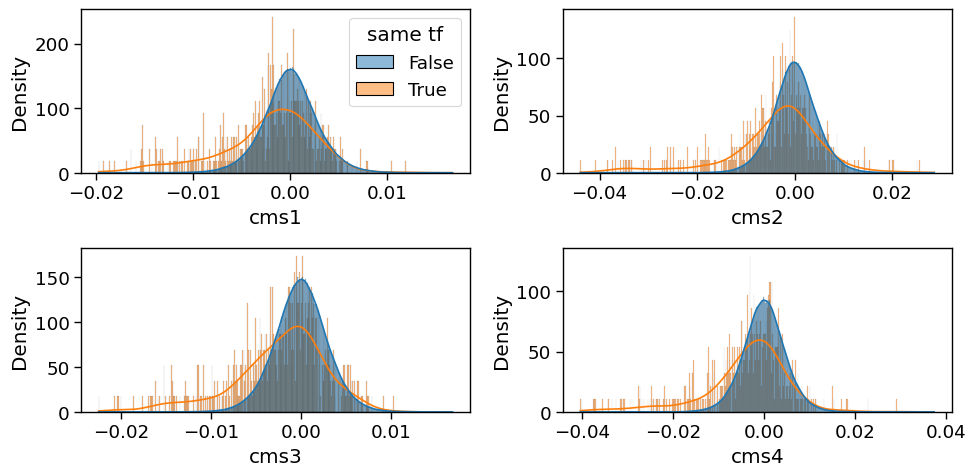

In [23]:
sns.set_context('paper', font_scale = 1.5)
dragon_trans['same tf'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)
f, ax = plt.subplots(2,2, figsize = (10,5))
sns.histplot(x = 'cms1', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[0][0])
sns.histplot(x = 'cms2', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[0][1])
sns.histplot(x = 'cms3', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[1][0])
sns.histplot(x = 'cms4', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[1][1])
ax[1][1].legend().remove()
ax[0][1].legend().remove()
ax[1][0].legend().remove()
plt.tight_layout()
f.savefig(output_folder+'dragon_sametf_values.pdf')

#### Is the pattern the same?
We now check if the above edges are correlated between different subtypes


/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

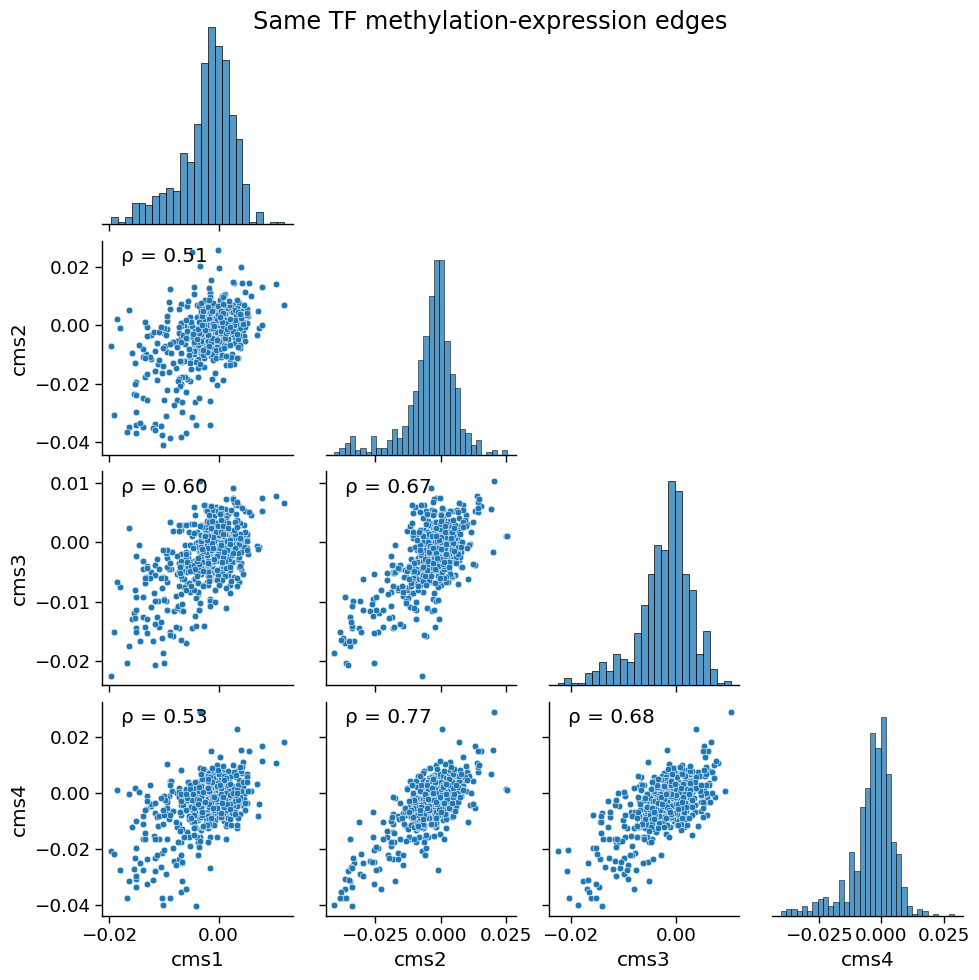

In [24]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
    
g = sns.pairplot(data = dragon_trans[dragon_trans['same']==1].loc[:,subtype_order].dropna(axis =0), corner = True)

g.map_lower(corrfunc)
g.fig.suptitle('Same TF methylation-expression edges')
g.fig.savefig(output_folder+'dragon_same_tf_edges.pdf')
plt.show()


#### What are the strongest of these edges?

We select the top 10% of these edges for each subtype

In [25]:
th = 0.1 #quantile threshold

dragon_trans_same = dragon_trans[dragon_trans['same']==1].copy()

for key in subtype_order:
    threshold = dragon_trans_same[key].dropna().quantile(th)
    print(key, threshold)
    dragon_trans_same[key+'_lower'] = dragon_trans_same[key] < threshold
dragon_trans_same['lower'] = np.sum(dragon_trans_same.loc[:,[key+'_lower' for key in subtype_order]], axis = 1)
dragon_trans_same.sort_values(by = 'lower', ascending = True)

cms1 -0.009595682997884509
cms2 -0.01590839262254296
cms3 -0.00930463111024202
cms4 -0.01560371809056855


node1               node2      cms1      cms2  \
edge                                                                           
TGIF2-TGIF2        TGIF2_methylation    TGIF2_expression -0.001997 -0.007947   
TEAD4-TEAD4        TEAD4_methylation    TEAD4_expression  0.001695 -0.003886   
TEF-TEF              TEF_methylation      TEF_expression  0.004885 -0.005492   
TERF2-TERF2        TERF2_methylation    TERF2_expression  0.003710 -0.003182   
TET1-TET1           TET1_methylation     TET1_expression       NaN -0.000144   
...                              ...                 ...       ...       ...   
ZNF264-ZNF264     ZNF264_methylation   ZNF264_expression -0.016763 -0.036306   
L3MBTL4-L3MBTL4  L3MBTL4_methylation  L3MBTL4_expression -0.013881 -0.034716   
ZNF570-ZNF570     ZNF570_methylation   ZNF570_expression -0.010478 -0.034512   
ZNF347-ZNF347     ZNF347_methylation   ZNF347_expression -0.011987 -0.035087   
ZNF785-ZNF785     ZNF785_methylation   ZNF785_expression -0.019204 -0.030469   

                     cms3      cms4      mean  abs_mean       var  \
edge                                                                
TGIF2-TGIF2     -0.007138  0.006296 -0.002696  0.005844  0.000043   
TEAD4-TEAD4     -0.000942 -0.008690 -0.002956  0.003803  0.000020   
TEF-TEF          0.005260 -0.003502  0.000288  0.004785  0.000031   
TERF2-TERF2     -0.004108  0.000892 -0.000672  0.002973  0.000013   
TET1-TET1             NaN  0.003581  0.001719  0.001863  0.000007   
...                   ...       ...       ...       ...       ...   
ZNF264-ZNF264   -0.020290 -0.037334 -0.027673  0.027673  0.000114   
L3MBTL4-L3MBTL4 -0.012655 -0.016434 -0.019421  0.019421  0.000106   
ZNF570-ZNF570   -0.013469 -0.026434 -0.021223  0.021223  0.000126   
ZNF347-ZNF347   -0.016706 -0.031007 -0.023697  0.023697  0.000123   
ZNF785-ZNF785   -0.015070 -0.021827 -0.021642  0.021642  0.000042   

                  node1_type  ...  cms2_abs  cms3_abs  cms4_abs  same  \
edge                          ...                                       
TGIF2-TGIF2      methylation  ...  0.007947  0.007138  0.006296     1   
TEAD4-TEAD4      methylation  ...  0.003886  0.000942  0.008690     1   
TEF-TEF          methylation  ...  0.005492  0.005260  0.003502     1   
TERF2-TERF2      methylation  ...  0.003182  0.004108  0.000892     1   
TET1-TET1        methylation  ...  0.000144       NaN  0.003581     1   
...                      ...  ...       ...       ...       ...   ...   
ZNF264-ZNF264    methylation  ...  0.036306  0.020290  0.037334     1   
L3MBTL4-L3MBTL4  methylation  ...  0.034716  0.012655  0.016434     1   
ZNF570-ZNF570    methylation  ...  0.034512  0.013469  0.026434     1   
ZNF347-ZNF347    methylation  ...  0.035087  0.016706  0.031007     1   
ZNF785-ZNF785    methylation  ...  0.030469  0.015070  0.021827     1   

                 same tf  cms1_lower  cms2_lower  cms3_lower  cms4_lower  \
edge                                                                       
TGIF2-TGIF2         True       False       False       False       False   
TEAD4-TEAD4         True       False       False       False       False   
TEF-TEF             True       False       False       False       False   
TERF2-TERF2         True       False       False       False       False   
TET1-TET1           True       False       False       False       False   
...                  ...         ...         ...         ...         ...   
ZNF264-ZNF264       True        True        True        True        True   
L3MBTL4-L3MBTL4     True        True        True        True        True   
ZNF570-ZNF570       True        True        True        True        True   
ZNF347-ZNF347       True        True        True        True        True   
ZNF785-ZNF785       True        True        True        True        True   

                 lower  
edge                    
TGIF2-TGIF2          0  
TEAD4-TEAD4          0  
TEF-TEF              0  
TERF2-TERF2          0  
TET

/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lower', ylabel='Count'>

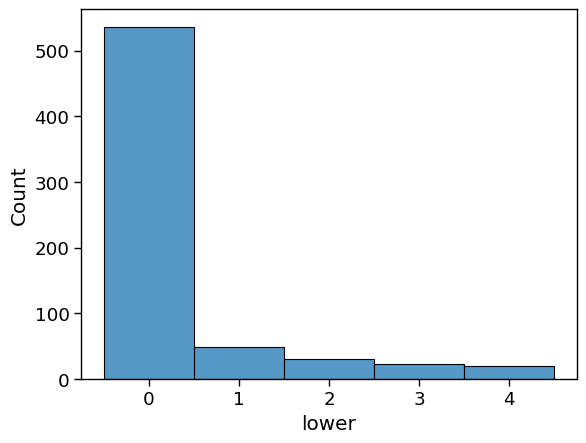

In [26]:
# How many TF are in the lower quantile for each subtype
sns.histplot(dragon_trans_same['lower'], bins = [0,1,2,3,4], discrete = True)

We consider as "silencing" the TFs that are lower in at least one subtype (we remove those that are never in the top 10%
of edges).

For these we check if they are known cancer genes by mapping them to the oncoKB database

In [27]:
#Here are the TF that are consistenly lower in all subtypes, that is the correlation between methylation and expression
#is lower than the threshold for 10th percentile
silencing_tf = dragon_trans_same[(dragon_trans_same['lower']>0)]
silencing_tf = silencing_tf.sort_values(by = 'lower', ascending = False).merge(oncokb, left_on = 'node1_tf', right_on = 'Hugo Symbol', how = 'left')
silencing_tf.fillna({'in_oncokb':False}, inplace = True)
silencing_tf.head()

/tmp/ipykernel_1855/1424856304.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  silencing_tf.fillna({'in_oncokb':False}, inplace = True)


node1              node2      cms1      cms2      cms3  \
0  ZNF570_methylation  ZNF570_expression -0.010478 -0.034512 -0.013469   
1  STAT5A_methylation  STAT5A_expression -0.015136 -0.023906 -0.015194   
2    BATF_methylation    BATF_expression -0.015101 -0.033872 -0.014537   
3  TFAP2C_methylation  TFAP2C_expression -0.009922 -0.025392 -0.020405   
4  ZNF256_methylation  ZNF256_expression -0.010198 -0.040821 -0.018633   

       cms4      mean  abs_mean       var   node1_type  ... Is Oncogene  \
0 -0.026434 -0.021223  0.021223  0.000126  methylation  ...         NaN   
1 -0.019534 -0.018443  0.018443  0.000018  methylation  ...         Yes   
2 -0.033500 -0.024253  0.024253  0.000119  methylation  ...         NaN   
3 -0.020194 -0.018978  0.018978  0.000042  methylation  ...         NaN   
4 -0.040137 -0.027447  0.027447  0.000238  methylation  ...         NaN   

  Is Tumor Suppressor Gene MSK-IMPACT  MSK-HEME  FOUNDATION ONE  \
0                      NaN        NaN       NaN             NaN   
1                       No        Yes       Yes              No   
2                      NaN        NaN       NaN             NaN   
3                      NaN        NaN       NaN             NaN   
4                      NaN        NaN       NaN             NaN   

   FOUNDATION ONE HEME  Vogelstein  SANGER CGC(05/30/2017)  Gene Aliases  \
0                  NaN         NaN                     NaN           NaN   
1                  Yes          No                      No         STAT5   
2                  NaN         NaN                     NaN           NaN   
3                  NaN         NaN                     NaN           NaN   
4                  NaN         NaN                     NaN           NaN   

   in_oncokb  
0      False  
1       True  
2      False  
3      False  
4      False  

[5 rows x 42 columns]

In [28]:
silencing_tf[silencing_tf['in_oncokb']]

node1               node2      cms1      cms2      cms3  \
1     STAT5A_methylation   STAT5A_expression -0.015136 -0.023906 -0.015194   
21   CREB3L1_methylation  CREB3L1_expression -0.008139 -0.027208 -0.011633   
25     ZNF24_methylation    ZNF24_expression -0.007492 -0.018965 -0.010804   
27     HMGA1_methylation    HMGA1_expression -0.001636 -0.025991 -0.009637   
31      IRF8_methylation     IRF8_expression -0.010377 -0.016238 -0.007749   
35      PAX8_methylation     PAX8_expression -0.006029 -0.036699 -0.016911   
72      CDX2_methylation     CDX2_expression -0.012309 -0.003249 -0.005065   
73   CREB3L2_methylation  CREB3L2_expression -0.000686 -0.016330 -0.007972   
78      TFEB_methylation     TFEB_expression -0.001996 -0.006433 -0.004726   
89       MGA_methylation      MGA_expression -0.007165 -0.018450 -0.005069   
92      NFIB_methylation     NFIB_expression       NaN       NaN -0.010805   
96      KLF6_methylation     KLF6_expression -0.003743 -0.014595 -0.008313   
97      LEF1_methylation     LEF1_expression -0.005775 -0.018239 -0.003831   
103   HOXD13_methylation   HOXD13_expression -0.013857 -0.008083 -0.003146   
107   HOXA13_methylation   HOXA13_expression -0.001632 -0.001792 -0.009837   
109   HOXB13_methylation   HOXB13_expression -0.015231 -0.012894 -0.007977   
114    GATA2_methylation    GATA2_expression -0.011572 -0.015498 -0.003839   

         cms4      mean  abs_mean       var   node1_type  ... Is Oncogene  \
1   -0.019534 -0.018443  0.018443  0.000018  methylation  ...         Yes   
21  -0.024436 -0.017854  0.017854  0.000088  methylation  ...          No   
25  -0.017376 -0.013659  0.013659  0.000029  methylation  ...          No   
27  -0.015608 -0.013218  0.013218  0.000105  methylation  ...         Yes   
31  -0.021497 -0.013965  0.013965  0.000038  methylation  ...          No   
35  -0.034400 -0.023510  0.023510  0.000214  methylation  ...         Yes   
72  -0.003925 -0.006137  0.006137  0.000017  methylation  ...          No   
73  -0.008205 -0.008298  0.008298  0.000041  methylation  ...          No   
78  -0.017454 -0.007652  0.007652  0.000046  methylation  ...          No   
89  -0.010862 -0.010387  0.010387  0.000035  methylation  ...          No   
92        NaN -0.010805  0.010805       NaN  methylation  ...          No   
96  -0.021956 -0.012151  0.012151  0.000063  methylation  ...          No   
97  -0.013949 -0.010448  0.010448  0.000046  methylation  ...          No   
103 -0.008330 -0.008354  0.008354  0.000019  methylation  ...          No   
107  0.000478 -0.003196  0.003435  0.000021  methylation  ...          No   
109  0.001972 -0.008532  0.009519  0.000058  methylation  ...         Yes   
114 -0.003598 -0.008627  0.008627  0.000035  methylation  ...         Yes   

    Is Tumor Suppressor Gene MSK-IMPACT  MSK-HEME  FOUNDATION ONE  \
1                         No        Yes       Yes              No   
21                        No         No        No              No   
25                        No         No        No              No   
27                        No         No        No              No   
31                       Yes         No       Yes              No   
35                        No         No        No              No   
72                        No         No        No              No   
73                        No         No        No              No   
78                        No         No        No              No   
89                       Yes        Yes       Yes              No   
92                        No         No        No              No   
96                        No         No        No              No   
97                        No         No        No              No   
103                       No         No        No              No   
107                       No         No        No              No   
109                      Yes        Yes       Yes              No   
114                       No        Yes       Yes     

/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-pa

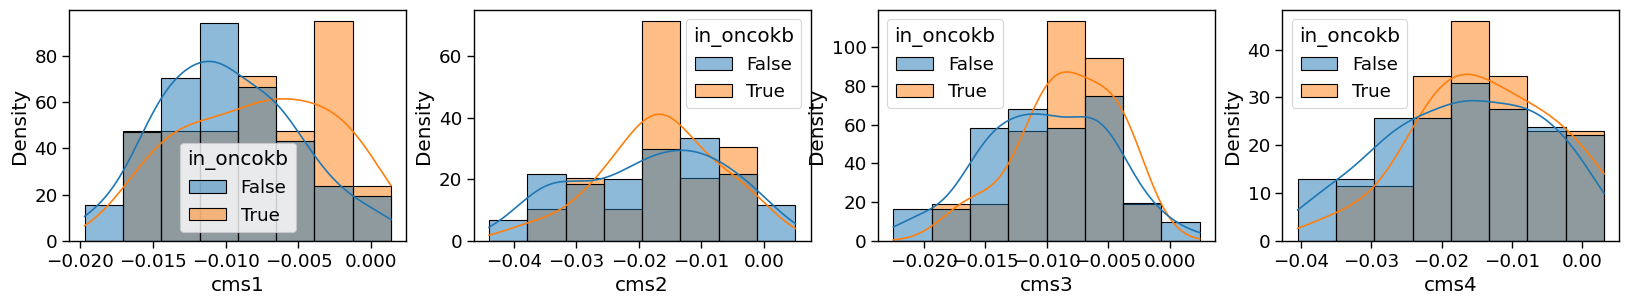

In [118]:
# Here we can check whether cancer genes are preferentially silenced by methylation, which doesn't seem to be the case
f, ax = plt.subplots(1,4, figsize = (20,3))
for ks, sss in enumerate(subtype_order):
    sns.histplot(silencing_tf, x = sss, hue = 'in_oncokb', stat = 'density', common_norm = False, kde = True, ax = ax[ks])

In [122]:
silencing_tf[silencing_tf['lower']==4][silencing_tf['in_oncokb']]

/tmp/ipykernel_1976/2582558435.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  silencing_tf[silencing_tf['lower']==4][silencing_tf['in_oncokb']]


node1              node2      cms1      cms2      cms3  \
1  STAT5A_methylation  STAT5A_expression -0.015136 -0.023906 -0.015194   

       cms4      mean  abs_mean       var   node1_type  ... Is Oncogene  \
1 -0.019534 -0.018443  0.018443  0.000018  methylation  ...         Yes   

  Is Tumor Suppressor Gene MSK-IMPACT  MSK-HEME  FOUNDATION ONE  \
1                       No        Yes       Yes              No   

   FOUNDATION ONE HEME  Vogelstein  SANGER CGC(05/30/2017)  Gene Aliases  \
1                  Yes          No                      No         STAT5   

   in_oncokb  
1       True  

[1 rows x 42 columns]

In [134]:
silencing_tf[silencing_tf['lower']>0][silencing_tf['in_oncokb']].to_csv(output_folder+'dragon_same_tf_edges_oncokb.csv')

Here we'll just print the names of the TF that have low values in each subtpye

In [129]:
', '.join(silencing_tf[silencing_tf['lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())

'STAT5A, CREB3L1, ZNF24, HMGA1, IRF8, PAX8, CDX2, CREB3L2, TFEB, MGA, NFIB, KLF6, LEF1, HOXD13, HOXA13, HOXB13, GATA2'

In [130]:
', '.join(silencing_tf[silencing_tf['cms4_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())

/tmp/ipykernel_1976/2636801738.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ', '.join(silencing_tf[silencing_tf['cms4_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())


'STAT5A, CREB3L1, ZNF24, HMGA1, IRF8, PAX8, TFEB, KLF6'

In [131]:
', '.join(silencing_tf[silencing_tf['cms2_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())

/tmp/ipykernel_1976/2444774491.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ', '.join(silencing_tf[silencing_tf['cms2_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())


'STAT5A, CREB3L1, ZNF24, HMGA1, IRF8, PAX8, CREB3L2, MGA, LEF1'

In [132]:
', '.join(silencing_tf[silencing_tf['cms1_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())

/tmp/ipykernel_1976/1196660495.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ', '.join(silencing_tf[silencing_tf['cms1_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())


'STAT5A, IRF8, CDX2, HOXD13, HOXB13, GATA2'

In [133]:
', '.join(silencing_tf[silencing_tf['cms3_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())

/tmp/ipykernel_1976/1373153197.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ', '.join(silencing_tf[silencing_tf['cms3_lower']>0][silencing_tf['in_oncokb']].node1_tf.tolist())


'STAT5A, CREB3L1, ZNF24, HMGA1, PAX8, NFIB, HOXA13'

## Methylation-expression edges between different TFs

Instead of focusing on silencing, we look at more complex associations between different TFs. 

First, we'll look at the data to see if there are patterns of correlations between the different subtypes

In [183]:
(dragon_trans.node1_type=='methylation').all(),(dragon_trans.node2_type=='expression').all()

(True, True)

/tmp/ipykernel_1976/4286086443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['abs_mean'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].mean(axis =1)
/tmp/ipykernel_1976/4286086443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['abs_var'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].var(axis =1)


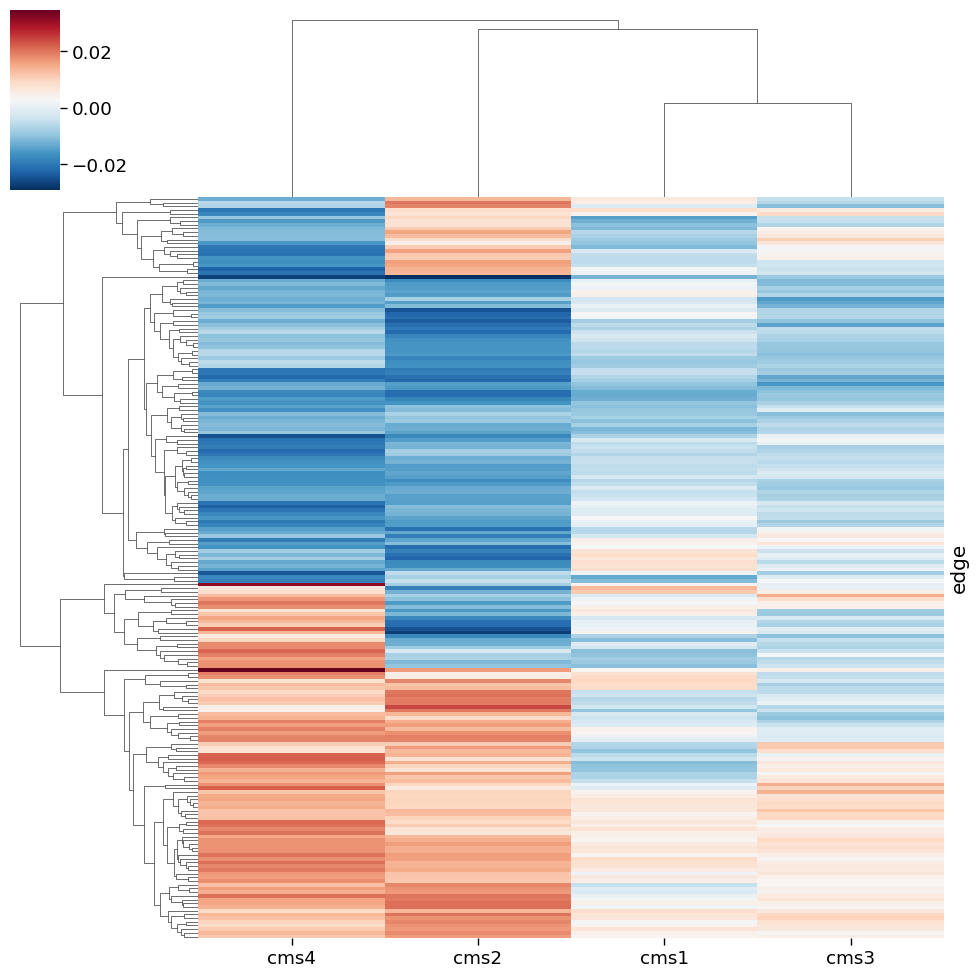

In [138]:
# top edges
K = 200 # this can be changed to include more or less edges, but you will see the cluster pattern to be similar
dragon_trans.loc[:, [i+'_abs' for i in subtype_order] ] = np.abs(dragon_trans.loc[:, subtype_order].values)
dragon_trans['abs_mean'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].mean(axis =1)
dragon_trans['abs_var'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].var(axis =1)

temp = dragon_trans[dragon_trans.node1_tf!=dragon_trans.node2_tf].dropna(subset= subtype_order, axis = 0).sort_values(by = 'abs_mean', ascending = False).iloc[:K,:].loc[:,subtype_order].fillna(0)
g1 = sns.clustermap(temp, cmap = 'RdBu_r', yticklabels = False)

Since we can distinctly recognize clusters of edges that are different between CMS2 and CMS4 we proceed to actually
cluster the data.

/tmp/ipykernel_1976/2319495232.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', len(temp['cluster'].unique()))


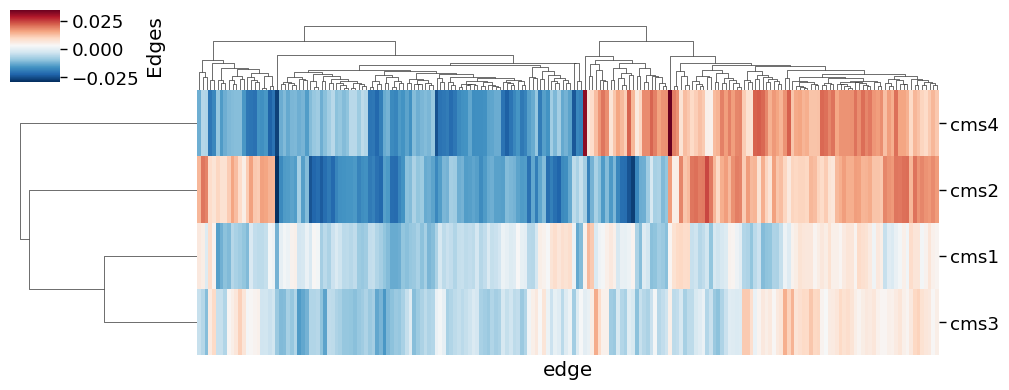

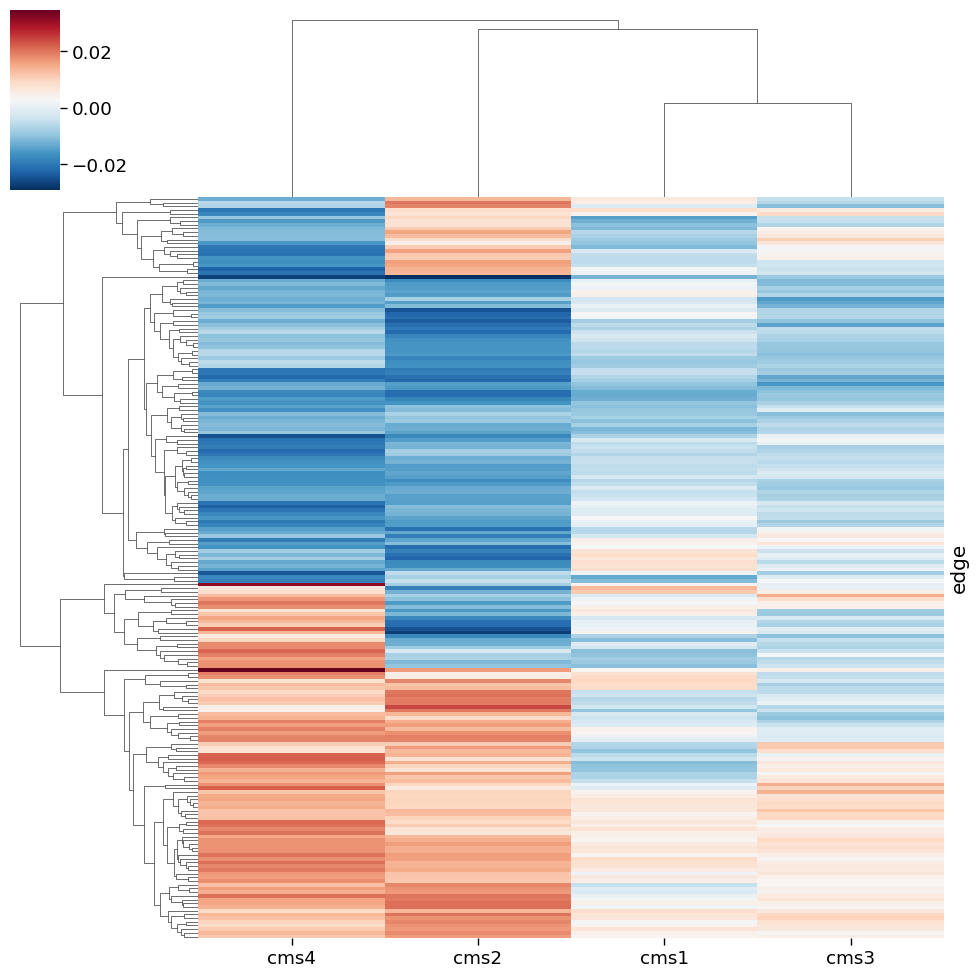

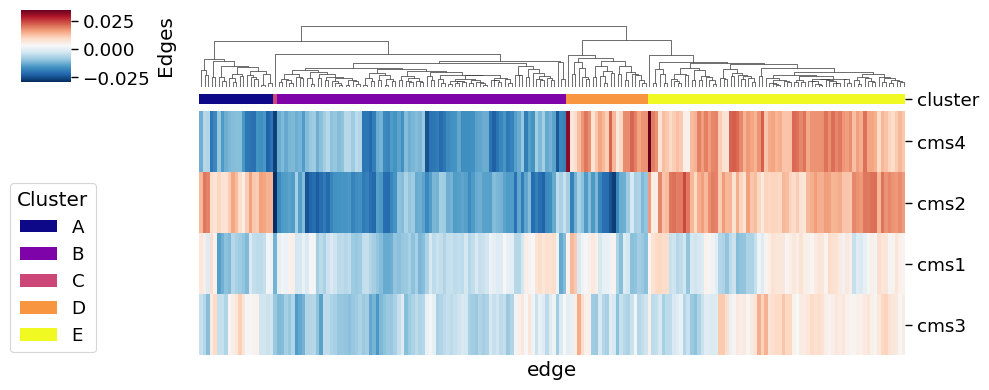

In [139]:
import scipy
import matplotlib
from matplotlib import cm as cm

temp = dragon_trans[dragon_trans.node1_tf!=dragon_trans.node2_tf].dropna(subset= subtype_order, axis = 0).sort_values(by = 'abs_mean', ascending = False).iloc[:K,:].loc[:,subtype_order].fillna(0)

g0 = sns.clustermap(temp.T, xticklabels = False,cmap = 'RdBu_r', cbar_kws={'label': 'Edges'}, yticklabels = True, figsize = (10,4))
# rotate the yticklabels of clustermap g1
g0.ax_heatmap.set_yticklabels(g0.ax_heatmap.get_yticklabels(), rotation=0)
g0.fig.savefig(output_folder+'all_cms_dragon_heatmap.pdf')

g1 = sns.clustermap(temp, cmap = 'RdBu_r', yticklabels = False)

temp['cluster_number'] = scipy.cluster.hierarchy.fcluster(g1.dendrogram_row.linkage, t = 5, criterion = 'maxclust')
# transform number to letter sequentially like a,B,C
temp['cluster'] = [chr(i+65) for i in temp['cluster_number']-1]

cmap = cm.get_cmap('plasma', len(temp['cluster'].unique()))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
lut = dict(zip(sorted(temp['cluster'].unique()), color_list))
row_colors = temp['cluster'].map(lut)
# change aspect to clustermap
g1 = sns.clustermap(temp.loc[:,subtype_order].T, col_colors=row_colors, xticklabels = False, 
               cmap = 'RdBu_r', cbar_kws={'label': 'Edges'}, yticklabels = True,
               figsize = (10,4))

# rotate the yticklabels of clustermap g1
g1.ax_heatmap.set_yticklabels(g1.ax_heatmap.get_yticklabels(), rotation=0)

from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Cluster',
           bbox_to_anchor=(0, 0.1), bbox_transform=plt.gcf().transFigure, loc='lower left')

# remove row dendrogram
g1.ax_row_dendrogram.set_visible(False)
g1.fig.savefig(output_folder+'all_cms_dragon_clustermap.pdf')


In [140]:
# We retrieve the clusters
clusts = {}
for i,tab in temp.groupby('cluster'):
    print(i, len(tab))
    meth = [i.split('-')[0] for i in tab.index]
    expr = [i.split('-')[1] for i in tab.index]
    all = meth+expr
    clusts[i] = {}
    clusts[i]['all'] = all
    clusts[i]['meth'] = meth
    clusts[i]['expr'] = expr

A 21
B 82
C 1
D 23
E 73


In [145]:
# we also have a table with the edge values, names and cluster number/name
temp


cms1      cms2      cms3      cms4  cluster_number cluster
edge                                                                          
ZNF345-ZNF790  -0.012222 -0.028967 -0.009026 -0.026827               3       C
HOXB5-HOXB6    -0.006764 -0.020931 -0.013662 -0.022181               2       B
HOXB8-HOXB6    -0.013081 -0.021357 -0.010234 -0.017450               2       B
HOXB8-HOXB5    -0.013158 -0.021508 -0.009058 -0.018268               2       B
HOXB5-HOXB4    -0.008069 -0.022063 -0.012032 -0.019201               2       B
...                  ...       ...       ...       ...             ...     ...
STAT5A-PPARG    0.000949 -0.014860 -0.007660 -0.013302               2       B
ZNF280D-ZNF513 -0.003187 -0.008399 -0.007266  0.017902               4       D
DOT1L-EVX1      0.004228 -0.010934  0.006868 -0.014698               2       B
MYOG-NFE2L3     0.004753 -0.011374 -0.008851  0.011738               4       D
THAP3-ZNF513   -0.001000 -0.012193 -0.005502 -0.018000               2       B

[200 rows x 6 columns]

/tmp/ipykernel_1976/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipykernel_1976/1055373860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipykernel_1976/1055373860.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

(21, 20)
(57, 20)


/tmp/ipykernel_1976/1129573019.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
/tmp/ipykernel_1976/1129573019.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)
/tmp/ipykernel_1976/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipyk

(82, 20)
(115, 20)


/tmp/ipykernel_1976/1129573019.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
/tmp/ipykernel_1976/1129573019.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)
/tmp/ipykernel_1976/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipyk

(1, 20)
(3, 20)


/tmp/ipykernel_1976/1129573019.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
/tmp/ipykernel_1976/1129573019.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)
/tmp/ipykernel_1976/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipyk

(23, 20)
(63, 20)


/tmp/ipykernel_1976/1129573019.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
/tmp/ipykernel_1976/1129573019.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)
/tmp/ipykernel_1976/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipyk

(73, 20)
(111, 20)


/tmp/ipykernel_1976/1129573019.py:36: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
/tmp/ipykernel_1976/1129573019.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)


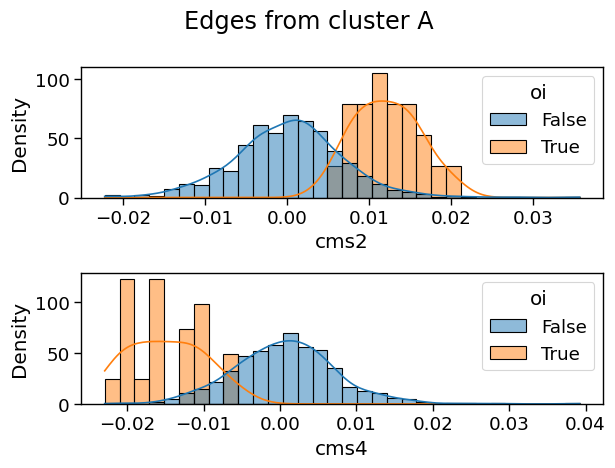

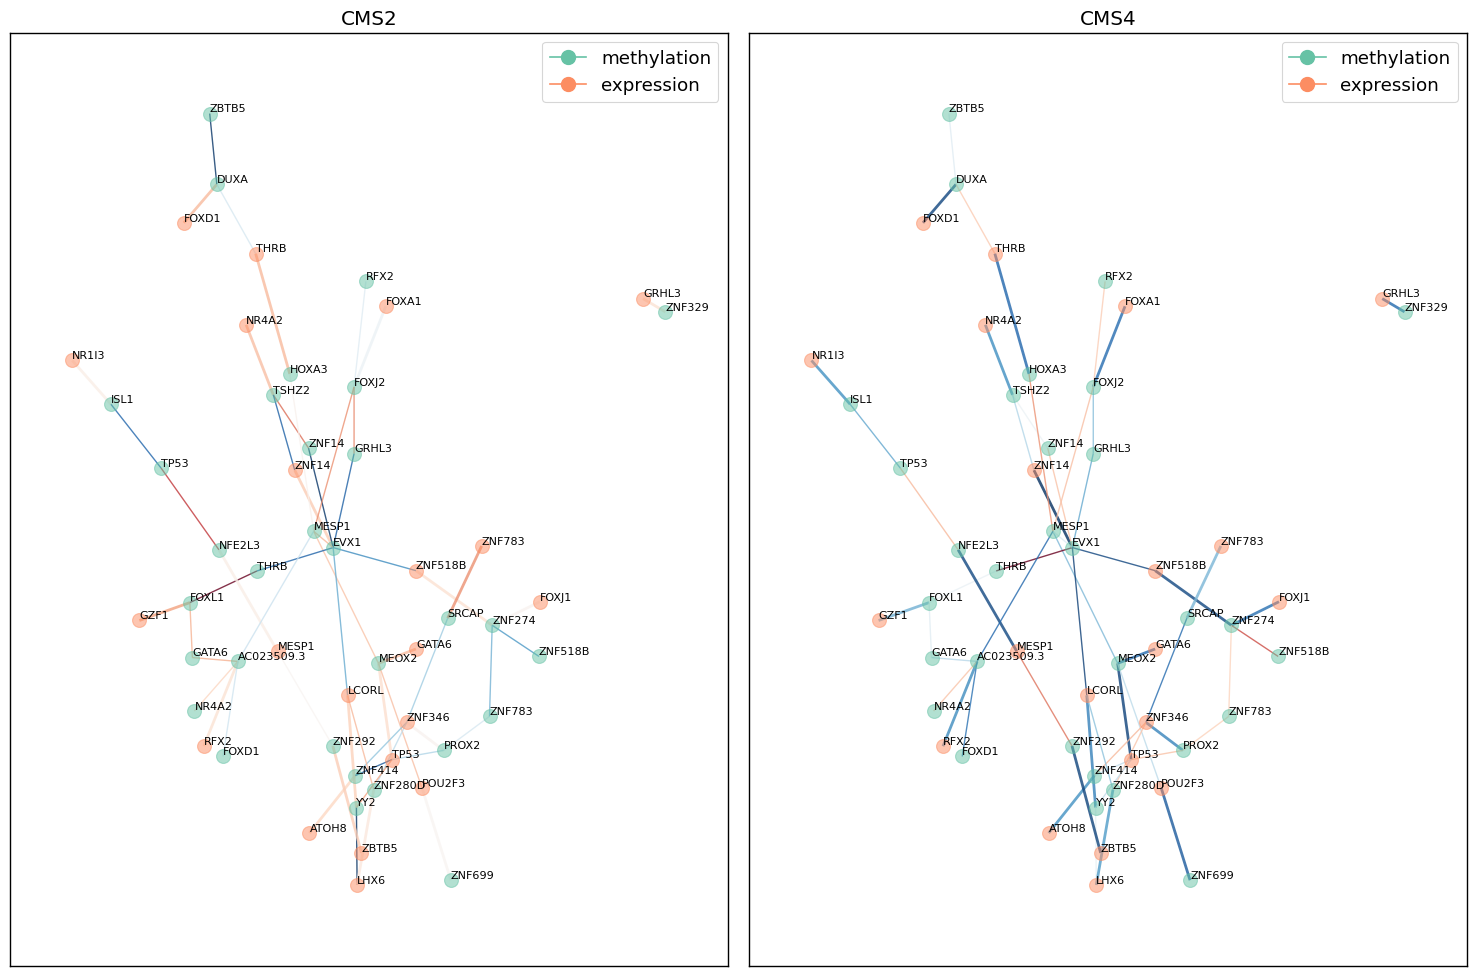

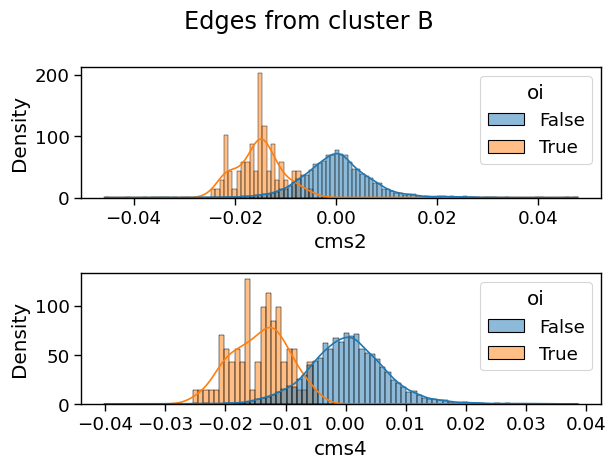

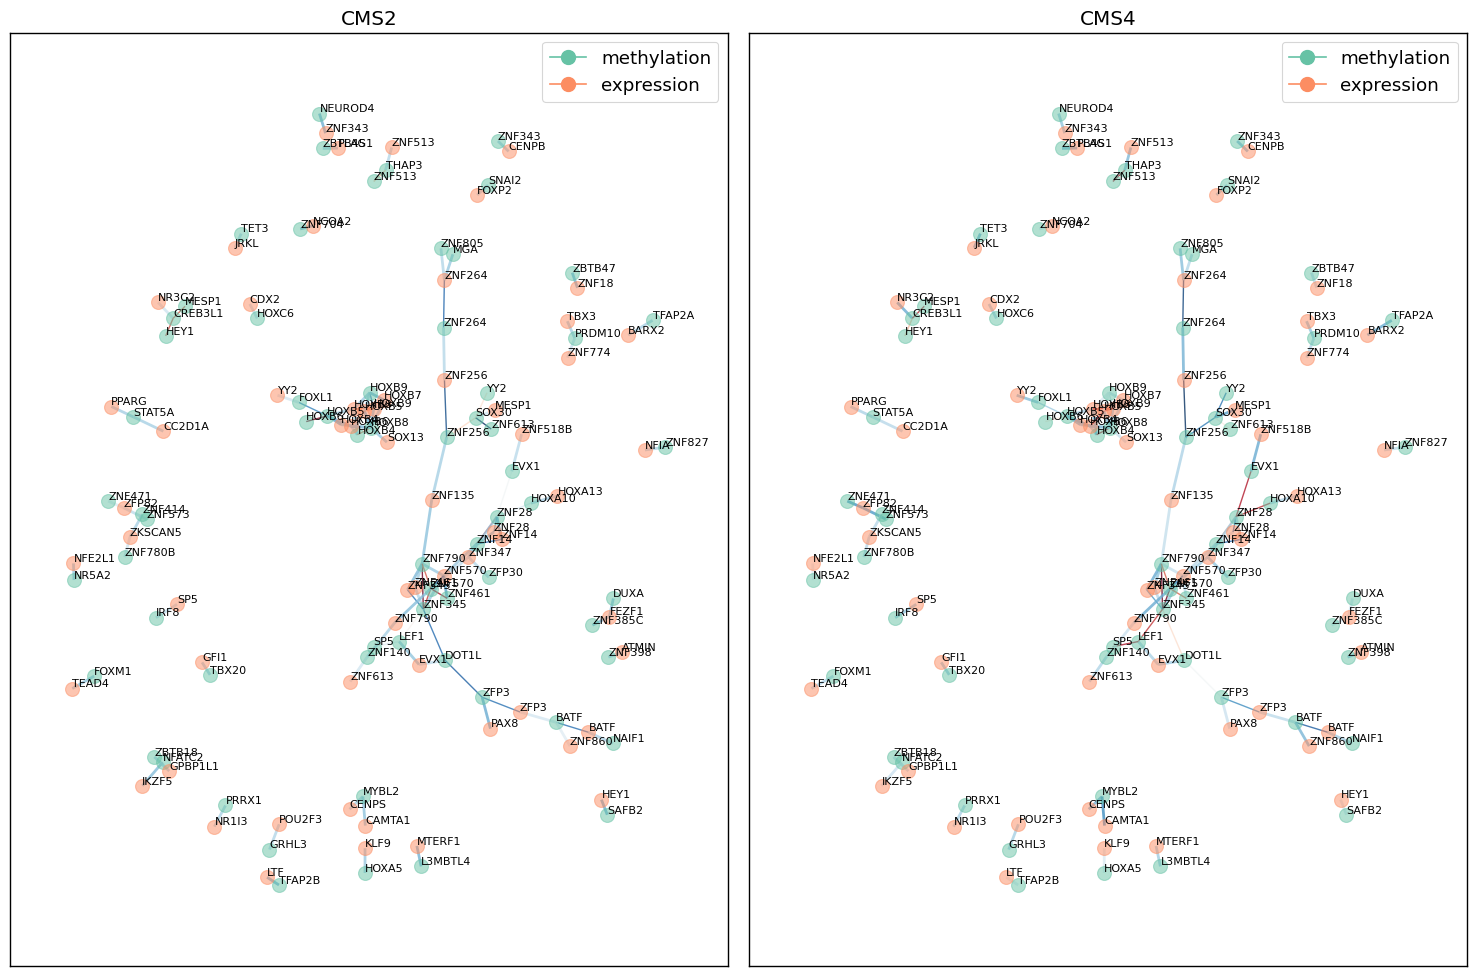

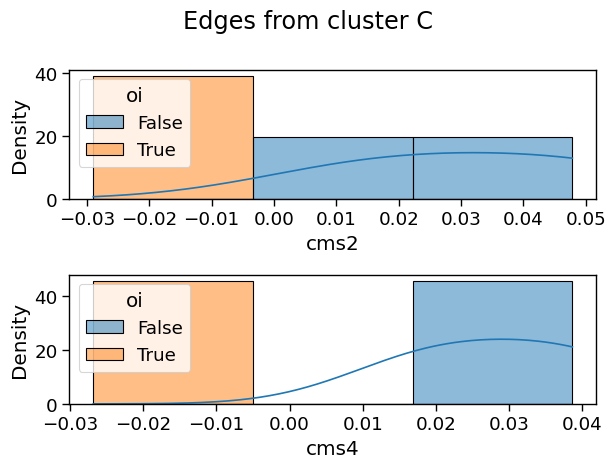

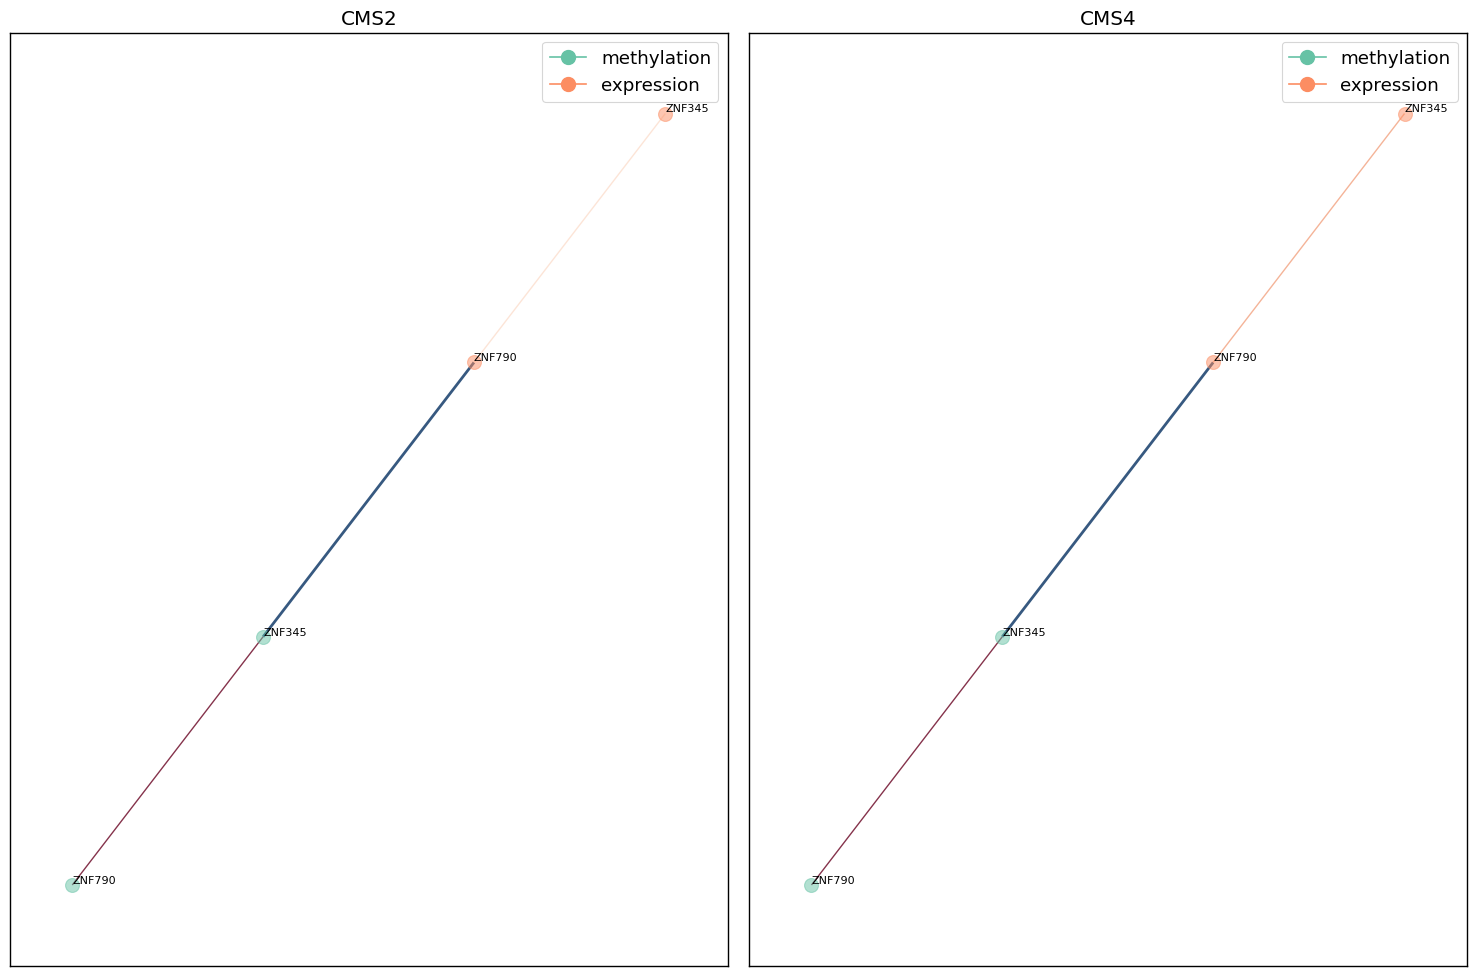

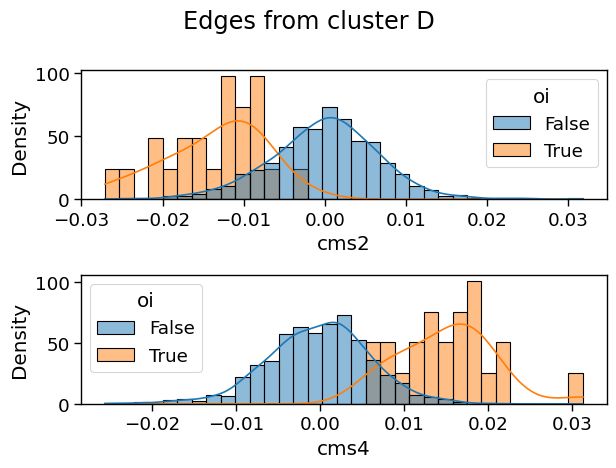

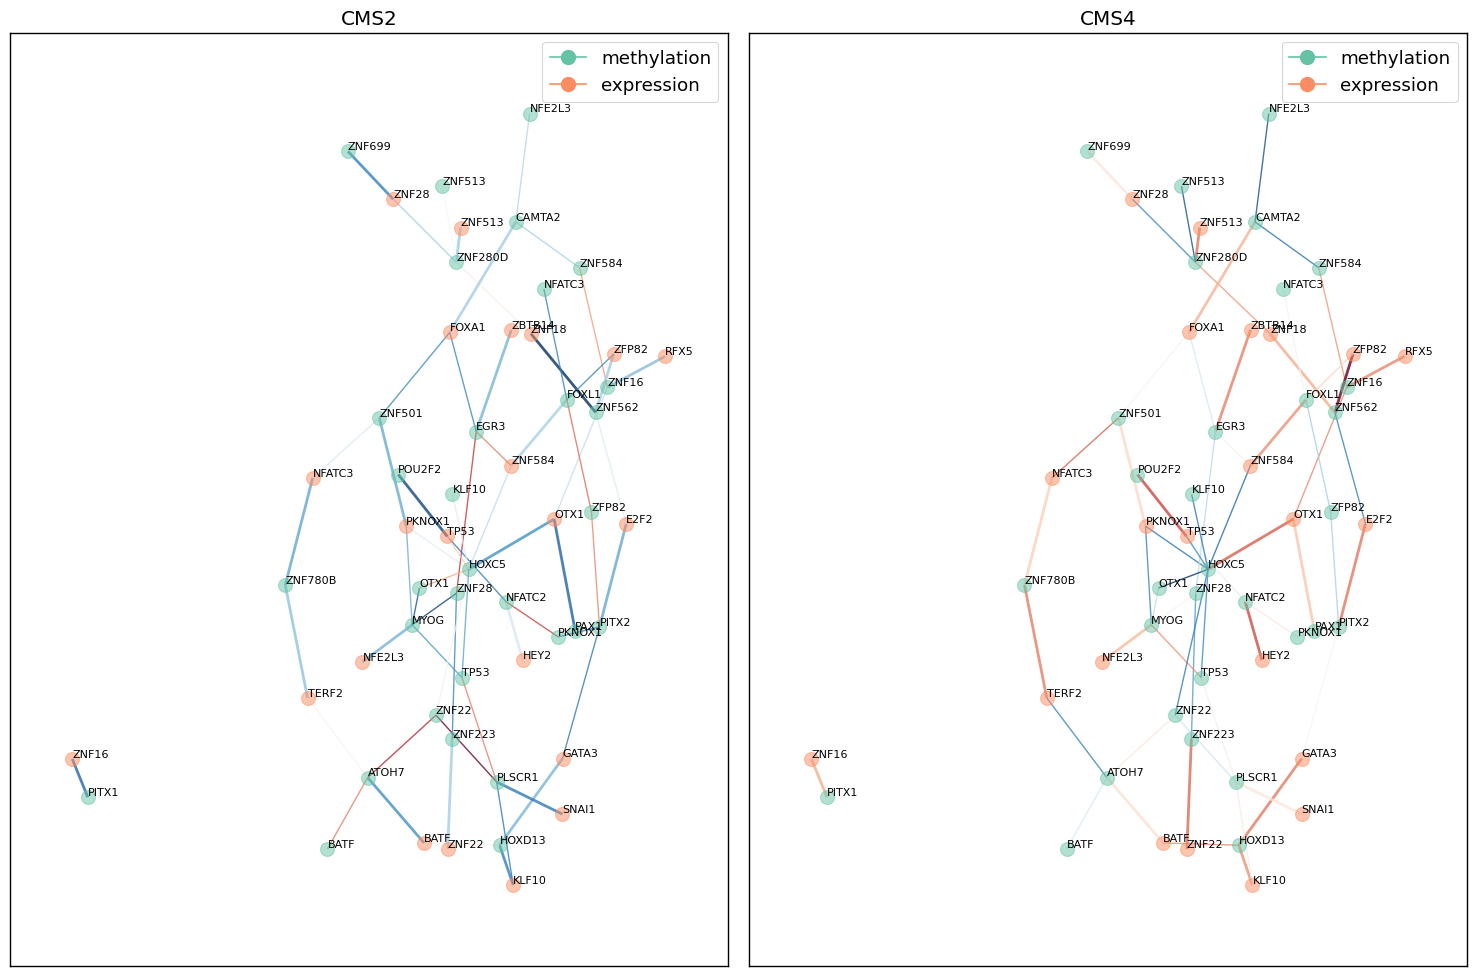

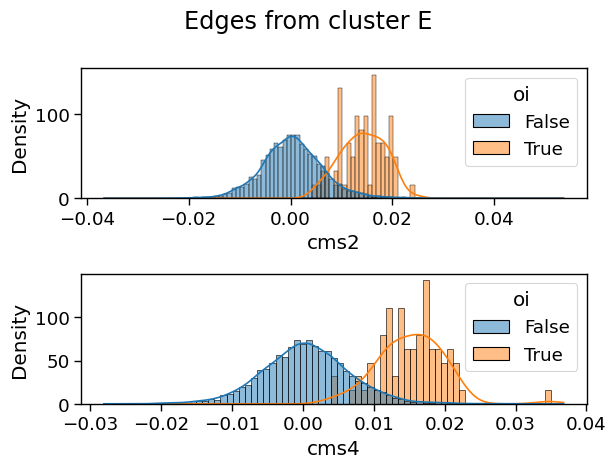

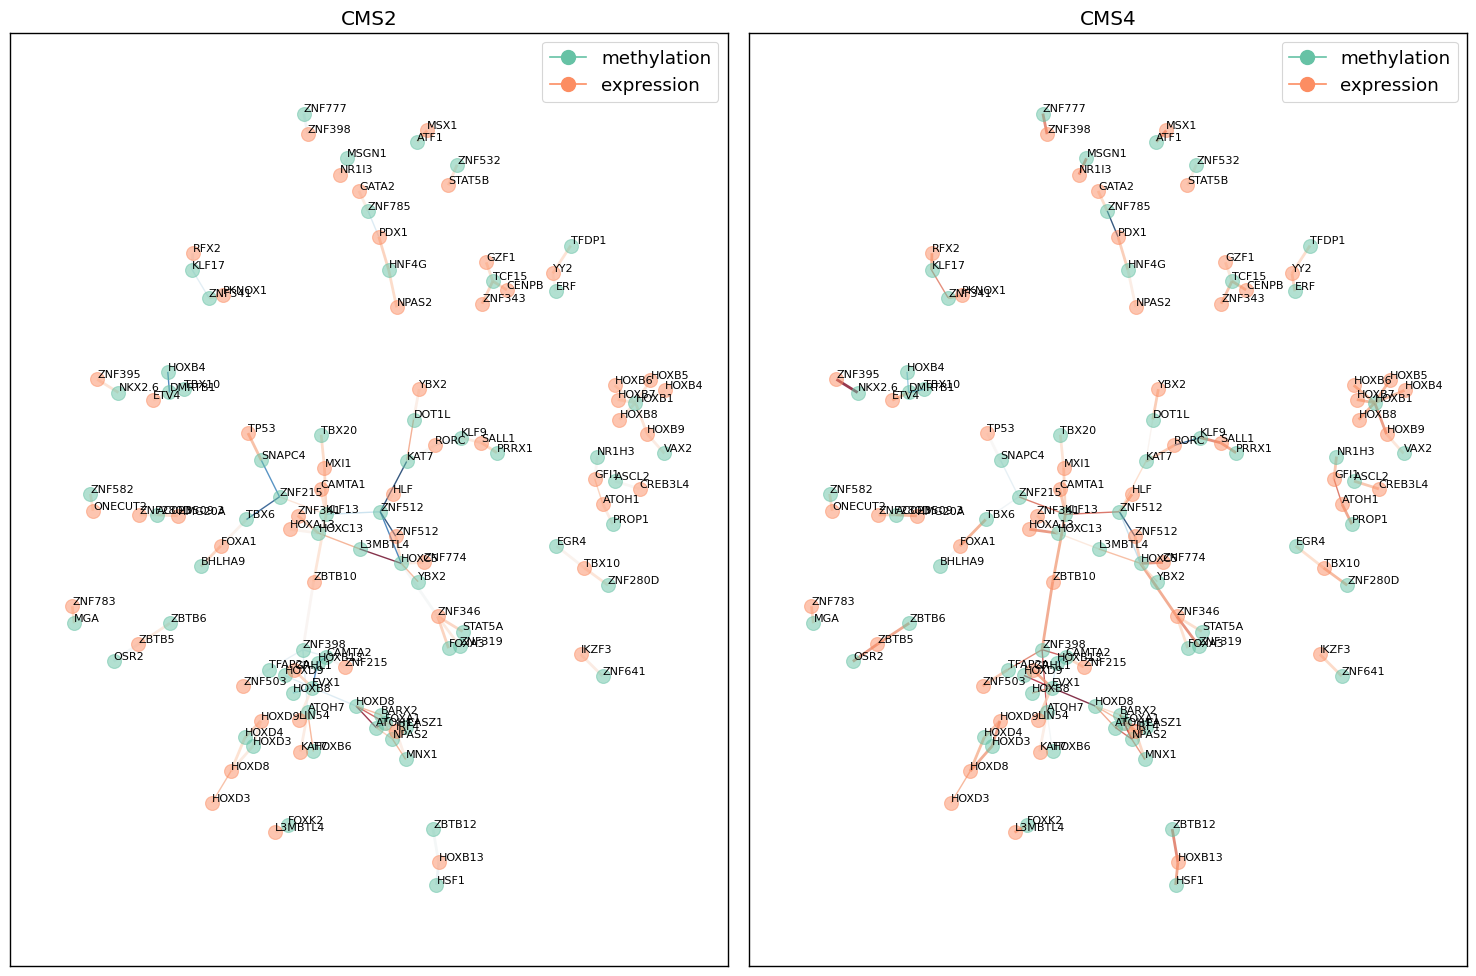

In [184]:
for k in clusts.keys():
    # We get the table with the edges of interest and the edges from the same nodes
    tf1 = [i.split('-')[0] for i in temp[temp['cluster']==k].index]
    tf2 = [i.split('-')[1] for i in temp[temp['cluster']==k].index]
    tf1_meth = [i.split('-')[0]+'_methylation' for i in temp[temp['cluster']==k].index]
    tf2_expr = [i.split('-')[1]+'_expression' for i in temp[temp['cluster']==k].index]
    
    complete_edges = [tf1_meth[i] +'-'+ tf2_expr[i] for i in range(len(tf1_meth))]

    dragon_oi = dragon[(dragon['node1_tf'].isin(tf1)) & (dragon['node2_tf'].isin(tf2)) ]
    dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
    dragon_oi['tf_edge'] = [dragon_oi.node1_tf[i] +'-'+ dragon_oi.node2_tf[i] for i in range(len(dragon_oi))]


    dragon_oi['oi'] = dragon_oi['complete_edge'].isin(complete_edges)
    dragon_oi = dragon_oi.set_index('complete_edge').sort_values(by = 'oi')
    
    # We save the table with the edges for each cluster (both those in the actual luster and those from the same tfs)
    dragon_oi.to_csv(output_folder + 'all_cms_dragon_clust%s.csv' %k)
    
    # Figure of edge of interest distribution
    f, ax = plt.subplots(2, 1)
    sns.histplot(x = 'cms2', hue = 'oi',data = dragon_oi, common_norm=False, kde = True, stat = 'density', ax = ax[0])
    sns.histplot(x = 'cms4', hue = 'oi',data = dragon_oi, common_norm=False, kde = True, stat = 'density', ax = ax[1])
    f.suptitle('Edges from cluster %s' %k)
    plt.tight_layout()
    f.savefig(output_folder + 'all_cms_edge_distribution_clust%s.pdf' %k)
    
    # Now we plot the graph
    # Get the graph
    graph_oi = dragon_oi[dragon_oi['oi']]
    dragonother = dragon_oi[~dragon_oi['oi']]
    # This would filter by edge values
    #dragon_graph = dragonother[(dragonother.cms2_abs>0.015) | (dragonother.cms4_abs>0.015)]
    
    # We filter the top edges
    K = 20
    dragon_other1 = dragonother.sort_values(by = 'cms2_abs', ascending = False).iloc[:K, :]
    dragon_other2 = dragonother.sort_values(by = 'cms4_abs', ascending = False).iloc[:K, :]
    dragon_graph = pd.concat([graph_oi, dragon_other1, dragon_other2], axis = 0).drop_duplicates()
    print(graph_oi.shape)
    print(dragon_graph.shape)
    
    
    
    import networkx as nx
    dragon_graph['edge_label_oi'] = ['*' if i==True else "" for i in dragon_graph['oi']]
    dragon_graph['edge_label_width'] = [2 if i==True else 1 for i in dragon_graph['oi']]
    G = nx.from_pandas_edgelist(dragon_graph, source = 'node1', target = 'node2', edge_attr = ['cms2', 'cms2_abs','cms4', 'cms4_abs', 'oi', 'edge_label_oi', 'edge_label_width'])
    

    draw_both_graphs(G, output_folder + 'all_cms_graph_cluster%s.pdf' %k)

    
    

#### We draw cluster D again, for better visualization

you can skip the following two cells, these are only made to reproduce the graph figure in the paper. It just cleans the
visualization compared to the grahs above.

In [200]:
for k in ['D']:
    # We get the table with the edges of interest and the edges from the same nodes
    tf1 = [i.split('-')[0] for i in temp[temp['cluster']==k].index]
    tf2 = [i.split('-')[1] for i in temp[temp['cluster']==k].index]
    tf1_meth = [i.split('-')[0]+'_methylation' for i in temp[temp['cluster']==k].index]
    tf2_expr = [i.split('-')[1]+'_expression' for i in temp[temp['cluster']==k].index]
    complete_edges = [tf1_meth[i] +'-'+ tf2_expr[i] for i in range(len(tf1_meth))]

    dragon_oi = dragon[(dragon['node1_tf'].isin(tf1)) & (dragon['node2_tf'].isin(tf2)) ]
    dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]

    dragon_oi['oi'] = dragon_oi['complete_edge'].isin(complete_edges)
    dragon_oi = dragon_oi.set_index('complete_edge').sort_values(by = 'oi')
    
    
    # Now we plot the graph
    
    # Get the graph
    graph_oi = dragon_oi[dragon_oi['oi']]
    dragonother = dragon_oi[~dragon_oi['oi']]
    # This would filter by edge values
    #dragon_graph = dragonother[(dragonother.cms2_abs>0.015) | (dragonother.cms4_abs>0.015)]
    # We filter the top edges
    K = 20
    dragon_other1 = dragonother.sort_values(by = 'cms2_abs', ascending = False).iloc[:K, :]
    dragon_other2 = dragonother.sort_values(by = 'cms4_abs', ascending = False).iloc[:K, :]
    dragon_graph = pd.concat([graph_oi, dragon_other1, dragon_other2], axis = 0).drop_duplicates()
    
    
    import networkx as nx
    dragon_graph['edge_label_oi'] = ['*' if i==True else "" for i in dragon_graph['oi']]
    dragon_graph['edge_label_width'] = [3 if i==True else 1 for i in dragon_graph['oi']]
    G = nx.from_pandas_edgelist(dragon_graph, source = 'node1', target = 'node2', edge_attr = ['cms2', 'cms2_abs','cms4', 'cms4_abs', 'oi', 'edge_label_oi', 'edge_label_width'])
    

/tmp/ipykernel_1976/2300356542.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipykernel_1976/2300356542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/tmp/ipykernel_1976/2300356542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_1976/4091101375.py:31: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)
/tmp/ipykernel_1976/4091101375.py:62: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)


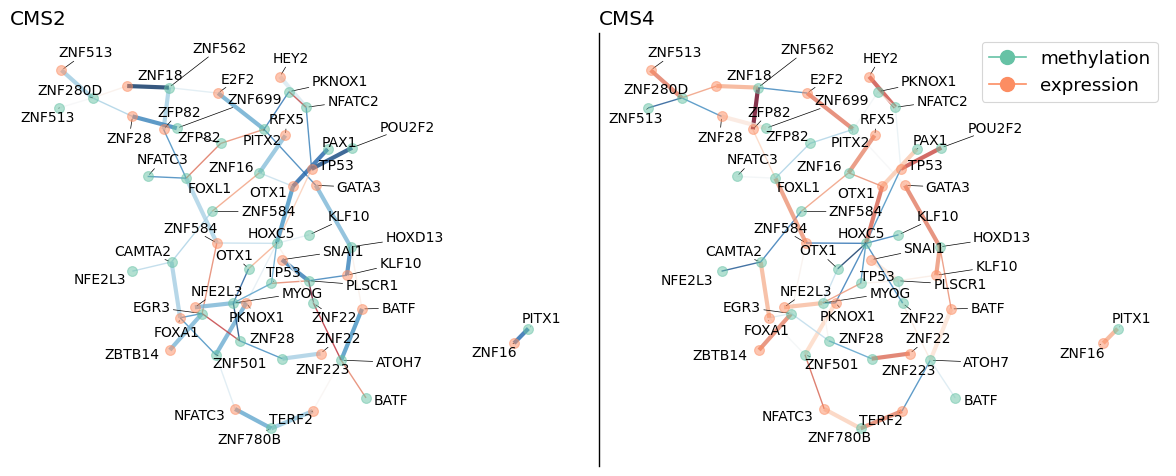

In [198]:

from adjustText import adjust_text
def draw_graphs_clusterd(G, fig_name):
    """Draw both graphs for CMS2 and CMS4"""
    
    pos = nx.spring_layout(G, seed=10, iterations=32,k=1/np.sqrt(G.order()))  # positions for all nodes
    #pos = nx.spectral_layout(G, scale=.1, center=None, dim=2)
    weights2 = nx.get_edge_attributes(G,'cms2').values()
    weights4 = nx.get_edge_attributes(G,'cms4').values()
    edge_labels = nx.get_edge_attributes(G,'edge_label_oi').values()
    edge_width = list(nx.get_edge_attributes(G,'edge_label_width').values())

    f,ax = plt.subplots(1,2,figsize = (12,5))
    options_node = {"node_size": 50, "alpha": 0.5}

    node_meth = [i  for i in list(G.nodes) if i.endswith('methylation') ]
    node_expr = [i  for i in list(G.nodes) if i.endswith('expression') ]

    # Methylation and expression nodes for CMS2
    nx.draw_networkx_nodes(G, pos, nodelist=node_meth, node_color="#66c2a5", **options_node, ax = ax[0])#, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=node_expr, node_color="#fc8d62", **options_node, ax = ax[0])#, edgecolors='k')

    # Node labels for methylation
    #nx.draw_networkx_labels(G, pos, {node_meth[k]:node_meth[k].split('_')[0] for k in range(len(node_meth))}, font_size=8, ax = ax[0], verticalalignment='bottom', horizontalalignment='left')
    #nx.draw_networkx_labels(G, pos, {node_meth[k]:node_meth[k].split('_')[0] for k in range(len(node_meth))}, font_size=8, ax = ax[1], verticalalignment='bottom', horizontalalignment='left')

    # Node labels for expression
    #nx.draw_networkx_labels(G, pos, {node_expr[k]:node_expr[k].split('_')[0] for k in range(len(node_expr))}, font_size=8, ax = ax[0], verticalalignment='bottom', horizontalalignment='left')
    #nx.draw_networkx_labels(G, pos, {node_expr[k]:node_expr[k].split('_')[0] for k in range(len(node_expr))}, font_size=8, ax = ax[1], verticalalignment='bottom', horizontalalignment='left')

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)

    #nx.draw_networkx_edge_labels(G, pos, edge_labels = nx.get_edge_attributes(G,'edge_label_oi'), ax = ax[0],  bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0})
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = nx.get_edge_attributes(G,'edge_label_oi'), ax = ax[1],  bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0})

    #nx.draw_networkx_labels(G_cms2, pos, {list(G_cms2.nodes)[k]:list(G_cms2.nodes)[k].split('_')[0] for k in range(len(G_cms2.nodes))}, font_size=9)


    meth_node = Line2D([0], [0], marker='o', color='#66c2a5', label='methylation',
                            markersize=10)
    expr_node = Line2D([0], [0], marker='o', color='#fc8d62', label='expression',
                            markersize=10)

    #ax[0].legend(handles=[meth_node, expr_node])
    ax[0].set_title('CMS2', loc = 'left')
    
    # Draw node labels separately
    labels = {node: node for node in G.nodes()}
    texts = []
    for node, (x, y) in pos.items():
        nodename = node.split('_')[0]
        texts.append(ax[0].text(x, y, str(nodename), fontsize=10, ha='center', va='center'))

    # Adjust the text labels to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax = ax[0])
    #f.savefig(fig_name)
    
    # Methylation and expression nodes for CMS4
    nx.draw_networkx_nodes(G, pos, nodelist=node_meth, node_color="#66c2a5", **options_node, ax = ax[1])#, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=node_expr, node_color="#fc8d62", **options_node, ax = ax[1])#, edgecolors='k')
    
    nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)
    
    ax[1].legend(handles=[meth_node, expr_node])
    
    # Draw node labels separately
    labels = {node: node for node in G.nodes()}
    texts2 = []
    for node, (x, y) in pos.items():
        nodename = node.split('_')[0]
        texts2.append(ax[1].text(x, y, str(nodename), fontsize=10, ha='center', va='center'))

    # Adjust the text labels to prevent overlap
    adjust_text(texts2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax = ax[1])
    ax[1].set_title('CMS4', loc = 'left')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    #remove the box around the axis
    #ax[0].axis('off')
    #ax[1].axis('off')
    for i in range(2):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    # add only one vertical line to the axis
    #ax[0].axvline(1.1, color='k', linestyle='--')
    plt.tight_layout()
    
    f.savefig(fig_name)

draw_graphs_clusterd(G, output_folder + 'all_cms_clean_graph_clusterD.pdf')

### Check cancer genes

For each of the clusters we check which TFs are known cancer genes using the oncoKB database


In [201]:
for c, d in clusts.items():
    print(c)
    print('All')
    oncokb['cluster'+c] = oncokb['Hugo Symbol'].isin(d['all'])

oncokb[oncokb['clusterA']]

A
All
B
All
C
All
D
All
E
All


Hugo Symbol  Entrez Gene ID   GRCh37 Isoform GRCh37 RefSeq  \
96         TP53            7157  ENST00000269305   NM_000546.5   
314       FOXA1            3169  ENST00000250448   NM_004496.3   
895       GATA6            2627              NaN           NaN   
907       HOXA3            3200              NaN           NaN   

      GRCh38 Isoform GRCh38 RefSeq  \
96   ENST00000269305   NM_000546.5   
314  ENST00000250448   NM_004496.3   
895              NaN           NaN   
907              NaN           NaN   

     # of occurrence within resources (Column D-J) OncoKB Annotated  \
96                                               7              Yes   
314                                              4              Yes   
895                                              1               No   
907                                              1               No   

    Is Oncogene Is Tumor Suppressor Gene  ... FOUNDATION ONE HEME Vogelstein  \
96           No                      Yes  ...                 Yes        Yes   
314         Yes                      Yes  ...                  No         No   
895          No                       No  ...                  No         No   
907          No                       No  ...                 Yes         No   

    SANGER CGC(05/30/2017) Gene Aliases in_oncokb clusterA clusterB  clusterC  \
96                     Yes    LFS1, p53      True     True    False     False   
314                    Yes        HNF3A      True     True    False     False   
895                     No          NaN      True     True    False     False   
907                     No        HOX1E      True     True    False     False   

     clusterD  clusterE  
96       True      True  
314      True      True  
895     False     False  
907     False     False  

[4 rows x 23 columns]

In [206]:
cluster_oncokb = oncokb[(oncokb['clusterD']) | (oncokb['clusterA']) | (oncokb['clusterB']) | (oncokb['clusterC']) | (oncokb['clusterE'])]
cluster_oncokb.to_csv(output_folder+'oncokb_clustered.csv')
cluster_oncokb

Hugo Symbol  Entrez Gene ID   GRCh37 Isoform   GRCh37 RefSeq  \
37        GATA3            2625  ENST00000346208     NM_002051.2   
96         TP53            7157  ENST00000269305     NM_000546.5   
144       GATA2            2624  ENST00000341105     NM_032638.4   
148        IRF4            3662  ENST00000380956     NM_002460.3   
217       DOT1L           84444  ENST00000398665     NM_032482.2   
264       PPARG            5468  ENST00000287820     NM_015869.4   
275      STAT5B            6777  ENST00000293328     NM_012448.3   
277        TBX3            6926  ENST00000257566     NM_016569.3   
308        ETV4            2118  ENST00000319349  NM_001079675.2   
314       FOXA1            3169  ENST00000250448     NM_004496.3   
358      STAT5A            6776  ENST00000345506     NM_003152.3   
376        ATF1             466  ENST00000262053     NM_005171.4   
406         ERF            2077  ENST00000222329     NM_006494.2   
449      HOXB13           10481  ENST00000290295     NM_006361.5   
454       IKZF3           22806  ENST00000346872     NM_012481.4   
461        IRF8            3394  ENST00000268638     NM_002163.2   
476         MGA           23269  ENST00000219905  NM_001164273.1   
604      CAMTA1           23261              NaN             NaN   
611        CDX2            1045              NaN             NaN   
620     CREB3L1           90993              NaN             NaN   
667        HEY1           23462              NaN             NaN   
670         HLF            3131              NaN             NaN   
672      HOXA13            3209              NaN             NaN   
675      HOXC13            3229              NaN             NaN   
677      HOXD13            3239              NaN             NaN   
694        LEF1           51176              NaN             NaN   
713       NCOA2           10499              NaN             NaN   
724        PAX8            7849  ENST00000263334     NM_003466.3   
734       PLAG1            5324              NaN             NaN   
740       PRRX1            5396              NaN             NaN   
783        TET3          200424  ENST00000409262       NM_144993   
895       GATA6            2627              NaN             NaN   
907       HOXA3            3200              NaN             NaN   
951        MNX1            3110              NaN             NaN   
961      NFATC2            4773              NaN             NaN   

      GRCh38 Isoform   GRCh38 RefSeq  \
37   ENST00000346208     NM_002051.2   
96   ENST00000269305     NM_000546.5   
144  ENST00000341105     NM_032638.4   
148  ENST00000380956     NM_002460.3   
217  ENST00000398665     NM_032482.2   
264  ENST00000287820     NM_015869.4   
275  ENST00000293328     NM_012448.3   
277  ENST00000257566     NM_016569.3   
308  ENST00000319349  NM_001079675.2   
314  ENST00000250448     NM_004496.3   
358  ENST00000345506     NM_003152.3   
376  ENST00000262053     NM_005171.4   
406  ENST00000222329     NM_006494.2   
449  ENST00000290295     NM_006361.5   
454  ENST00000346872     NM_012481.4   
461  ENST00000268638     NM_002163.2   
476  ENST00000219905  NM_001164273.1   
604              NaN             NaN   
611              NaN             NaN   
620              NaN             NaN   
667              NaN             NaN   
670              NaN             NaN   
672              NaN             NaN   
675              NaN             NaN   
677              NaN             NaN   
694              NaN             NaN   
713              NaN             NaN   
724  ENST00000348715     NM_003466.3   
734              NaN             NaN   
740              NaN             NaN   
783  ENST00000409262       NM_144993   
895              NaN             NaN   
907              NaN             NaN   
951              NaN             NaN   
961              NaN             NaN   

     # of occurrence within resources (Column D-J) OncoKB Annotated  \
37                                         

### Pathways for each cluster

For each cluster we do a pathway analysis with REACTOME 

In [212]:
hierarchy = pd.read_csv(reactome_hierarchy_fn)

import gseapy as gp
bckg = set(dragon.node1_tf).union(set(dragon.node2_tf))
bckg_meth = set(dragon.node1_tf)
bckg_expr = set(dragon.node2_tf)
res_all = {}
res_expr = {}
res_meth = {}
for key, items in clusts.items():
    if len(items['all'])>10:
        res_all[key] = gp.enrich(gene_list=items['all'], gene_sets=reactome_gmt_fn, background = bckg)
        res_expr[key] = gp.enrich(gene_list=items['expr'], gene_sets=reactome_gmt_fn, background = bckg_expr)
        res_meth[key] = gp.enrich(gene_list=items['meth'], gene_sets=reactome_gmt_fn, background = bckg_meth)
        
        res_all[key].res2d.to_csv(output_folder+'all_cms_enrich_all_clust%s.tsv' %key, sep = '\t')
        res_expr[key].res2d.to_csv(output_folder+'all_cms_enrich_expr_clust%s.tsv' %key, sep = '\t')
        res_meth[key].res2d.to_csv(output_folder+'all_cms_enrich_meth_clust%s.tsv' %key, sep = '\t')

We plot the annotation for each TF to the respective REACTOME terms

/tmp/ipykernel_1976/3928393110.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/tmp/ipykernel_1976/3928393110.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/tmp/ipykernel_1976/3928393110.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/tmp/ipykernel_1976/3928393110.py:12: MatplotlibDeprecationWarning: The get_cmap f

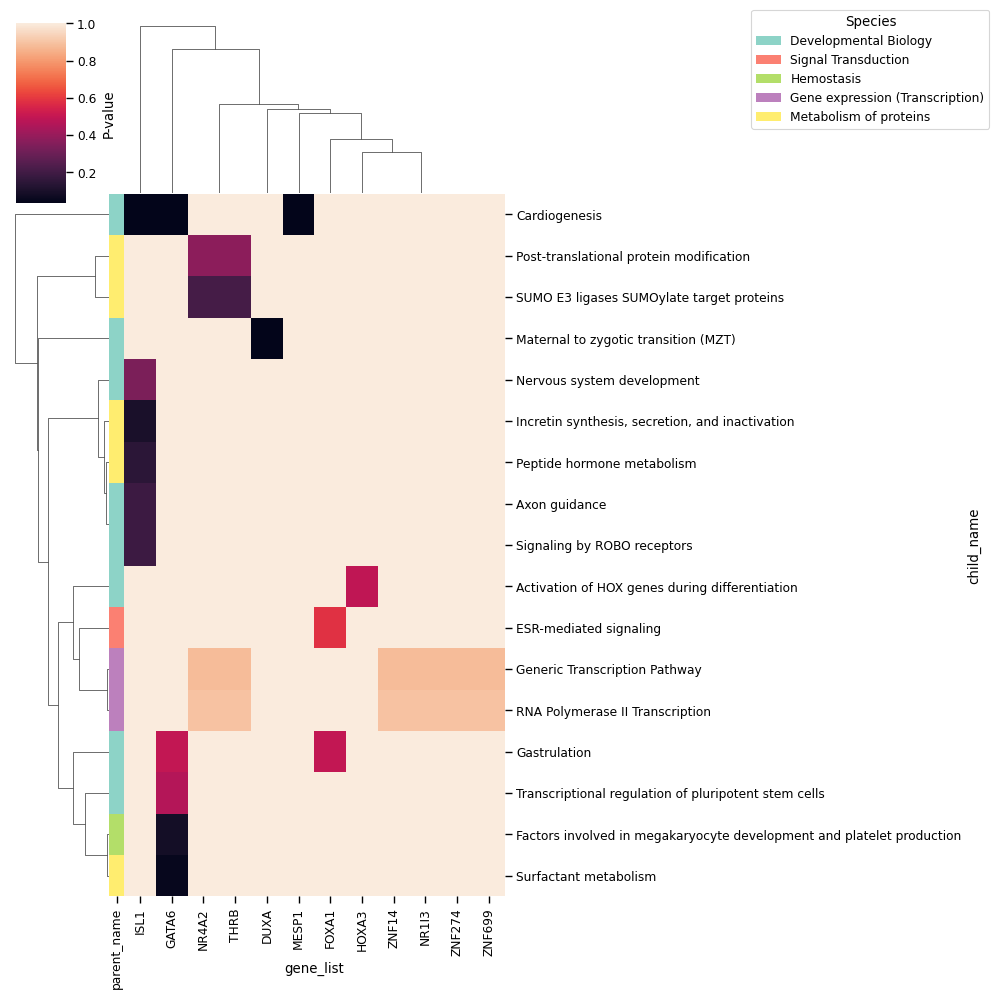

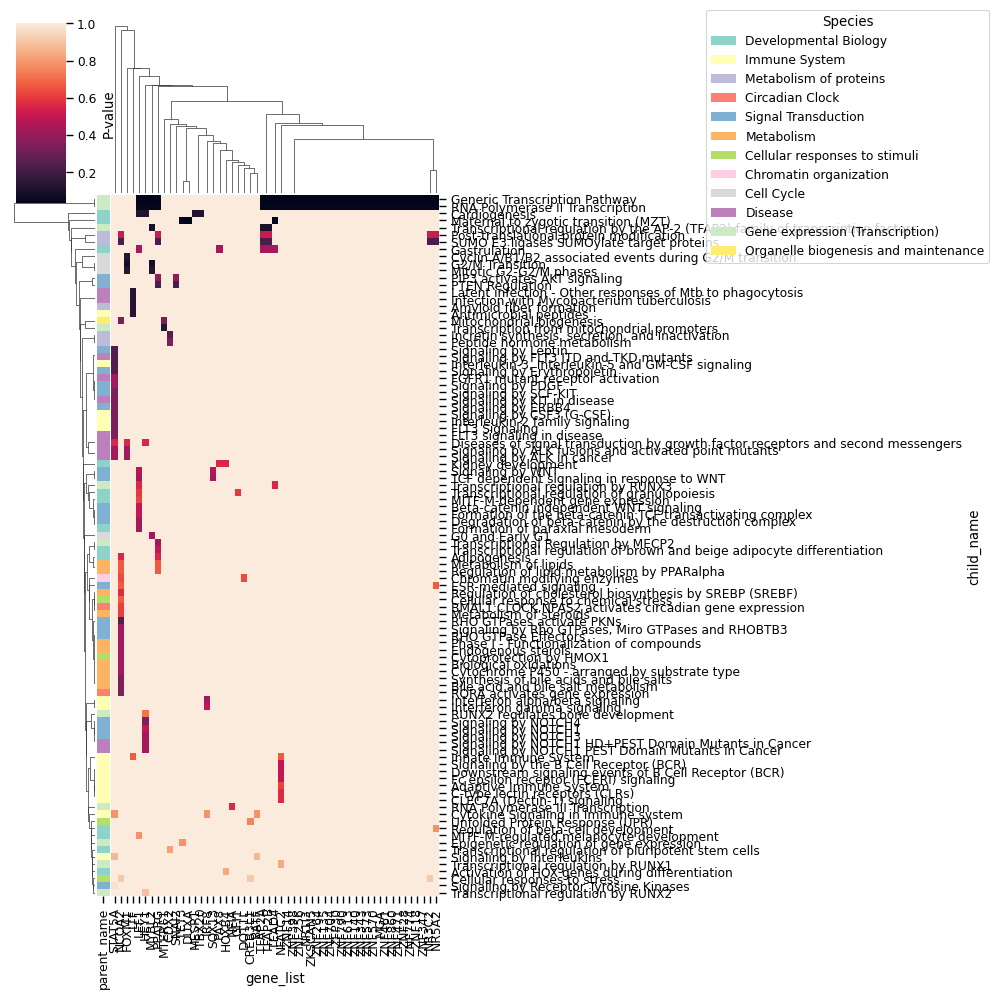

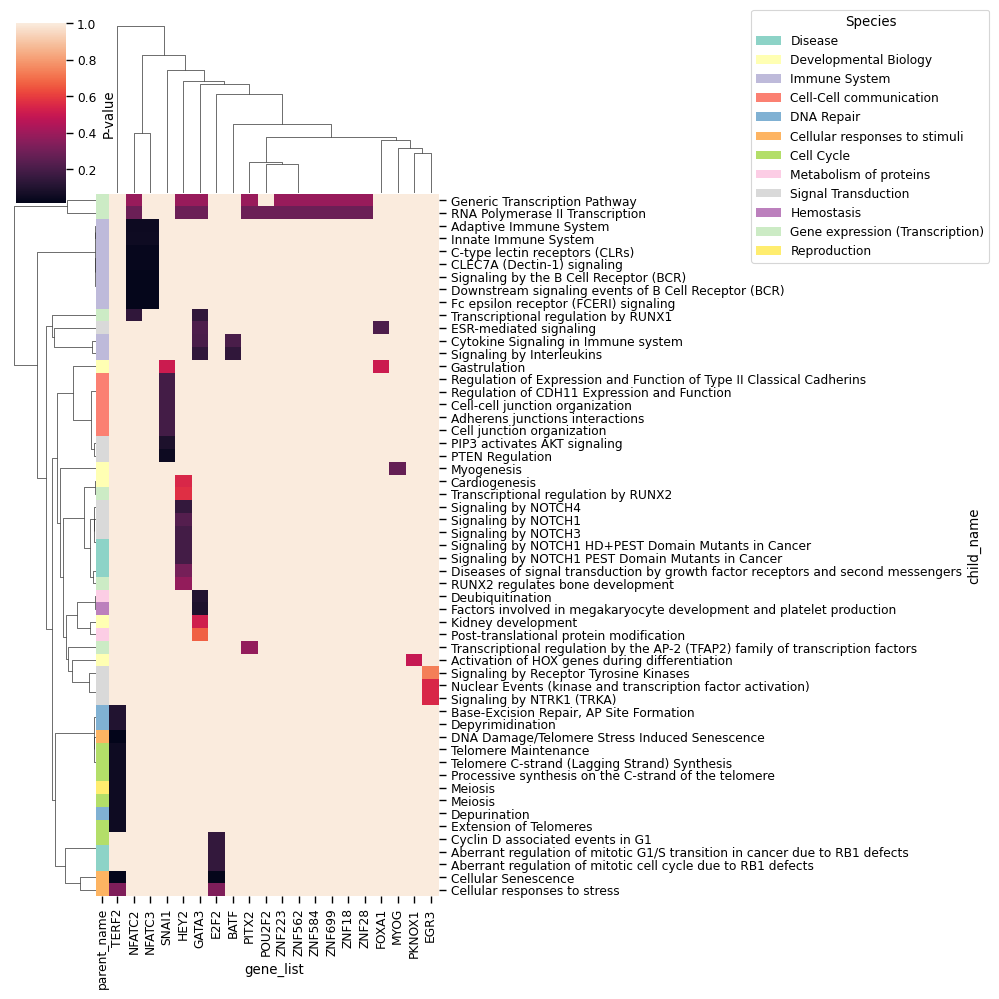

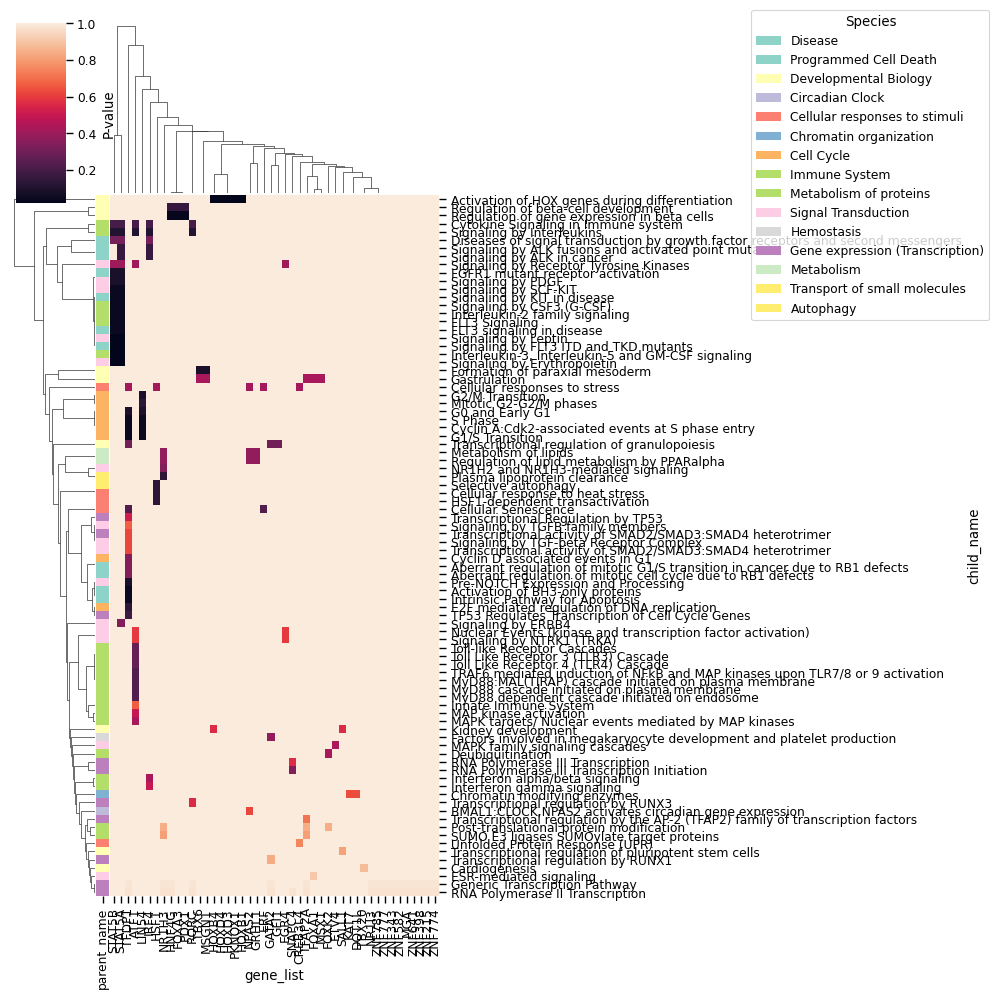

In [213]:

for key, items in res_all.items():
    res_all[key].res2d['gene_list'] = [i.split(';') for i in res_all[key].res2d.Genes]
    res_all
    mytab = pd.pivot_table(res_all[key].res2d.explode('gene_list'), index = 'Term', columns= 'gene_list', values='P-value')
    notp53 = list(set(mytab.columns.tolist()).difference(set(['TP53'])))
    mytab = mytab.loc[:,notp53].dropna(axis = 0,how = 'all').fillna(1)

    mytab_genes = mytab.columns
    mytab_full = mytab.merge(hierarchy, left_index=True, right_on = 'child_name').set_index('child_name')

    column = mytab_full['parent_name']
    cmap = cm.get_cmap('Set3', len(column.unique()))
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    lut = dict(zip(column.unique(), color_list))
    row_colors = column.map(lut)
    sns.set_context('paper')



    g1 = sns.clustermap(mytab_full.loc[:,mytab_genes], row_colors=row_colors, yticklabels = 1, xticklabels = 1, cbar_kws={'label': 'P-value'})
    plt.setp(g1.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)


    from matplotlib.patches import Patch

    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Species',
            bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    g1.fig.savefig(output_folder+'all_cms_pathway_tfs_all_clustermap_cluster%s.pdf' %key, bbox_inches = 'tight')

Same plot but cleaner, annotation only

A
                 Gene_set                                            Term  \
0  hugo_reactome_slim.gmt                 Activation of BH3-only proteins   
1  hugo_reactome_slim.gmt  Activation of HOX genes during differentiation   
2  hugo_reactome_slim.gmt     Antiviral mechanism by IFN-stimulated genes   
3  hugo_reactome_slim.gmt                                   Axon guidance   
4  hugo_reactome_slim.gmt                                   Cardiogenesis   

  Overlap   P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0     1/3  0.141784          0.354460   11.612658       22.684751   
1    1/13  0.486666          0.575150    2.292152        1.650757   
2     1/4  0.184535          0.374836    8.283906       13.999128   
3     1/4  0.184535          0.374836    8.283906       13.999128   
4    3/15  0.034024          0.293255    5.633600       19.045471   

              Genes             gene_list  
0              TP53                [TP53]  
1             HOXA3             

/tmp/ipykernel_1976/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))


B
                 Gene_set                                            Term  \
0  hugo_reactome_slim.gmt  Activation of HOX genes during differentiation   
1  hugo_reactome_slim.gmt                          Adaptive Immune System   
2  hugo_reactome_slim.gmt                                    Adipogenesis   
3  hugo_reactome_slim.gmt                         Amyloid fiber formation   
4  hugo_reactome_slim.gmt                          Antimicrobial peptides   

  Overlap   P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0    1/13  0.836420          0.872012    0.800580        0.143003   
1     1/7  0.621271          0.770691    1.552954        0.739187   
2    2/14  0.557529          0.747819    1.347317        0.787157   
3     1/1  0.129032          0.744469   20.362319       41.695775   
4     1/1  0.129032          0.744469   20.362319       41.695775   

         Genes       gene_list  
0        HOXB4         [HOXB4]  
1       NFATC2        [NFATC2]  
2  PPARG;NCOA2  [PPAR

/tmp/ipykernel_1976/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))


D
                 Gene_set                                               Term  \
0  hugo_reactome_slim.gmt  Aberrant regulation of mitotic G1/S transition...   
1  hugo_reactome_slim.gmt  Aberrant regulation of mitotic cell cycle due ...   
2  hugo_reactome_slim.gmt                    Activation of BH3-only proteins   
3  hugo_reactome_slim.gmt     Activation of HOX genes during differentiation   
4  hugo_reactome_slim.gmt                             Adaptive Immune System   

  Overlap   P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0     1/3  0.145145          0.290290   11.311111       21.830679   
1     1/3  0.145145          0.290290   11.311111       21.830679   
2     1/3  0.145145          0.290290   11.311111       21.830679   
3    1/13  0.495378          0.554351    2.232593        1.568250   
4     2/7  0.045085          0.199235    8.751438       27.122565   

           Genes         gene_list  
0           E2F2            [E2F2]  
1           E2F2            

/tmp/ipykernel_1976/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))


E
                 Gene_set                                               Term  \
0  hugo_reactome_slim.gmt  Aberrant regulation of mitotic G1/S transition...   
1  hugo_reactome_slim.gmt  Aberrant regulation of mitotic cell cycle due ...   
2  hugo_reactome_slim.gmt                    Activation of BH3-only proteins   
3  hugo_reactome_slim.gmt     Activation of HOX genes during differentiation   
4  hugo_reactome_slim.gmt        Antiviral mechanism by IFN-stimulated genes   

  Overlap   P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0     1/3  0.339662          0.531021    4.060870        4.384943   
1     1/3  0.339662          0.531021    4.060870        4.384943   
2     2/3  0.045340          0.279597   11.406504       35.286739   
3    5/13  0.017858          0.279597    4.516406       18.179999   
4     1/4  0.425185          0.568923    2.896480        2.477157   

                            Genes                             gene_list  
0                           

/tmp/ipykernel_1976/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))


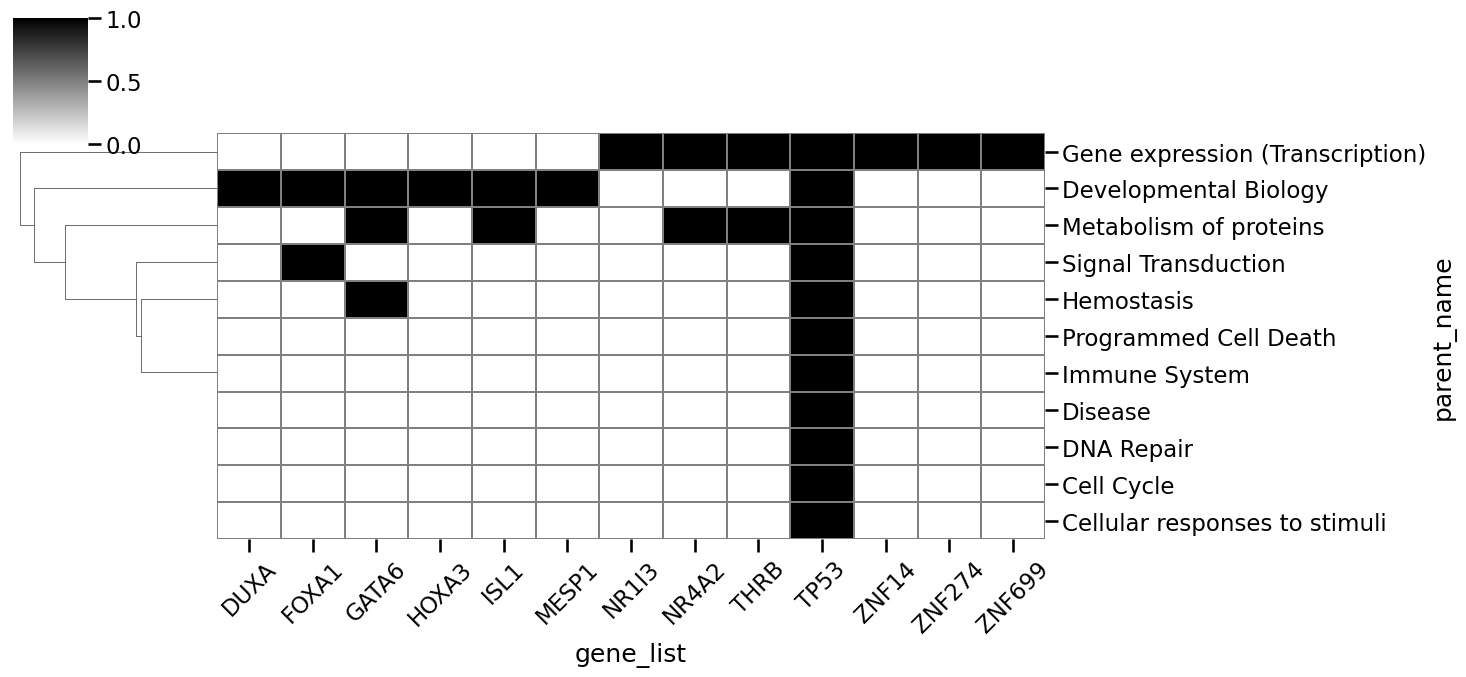

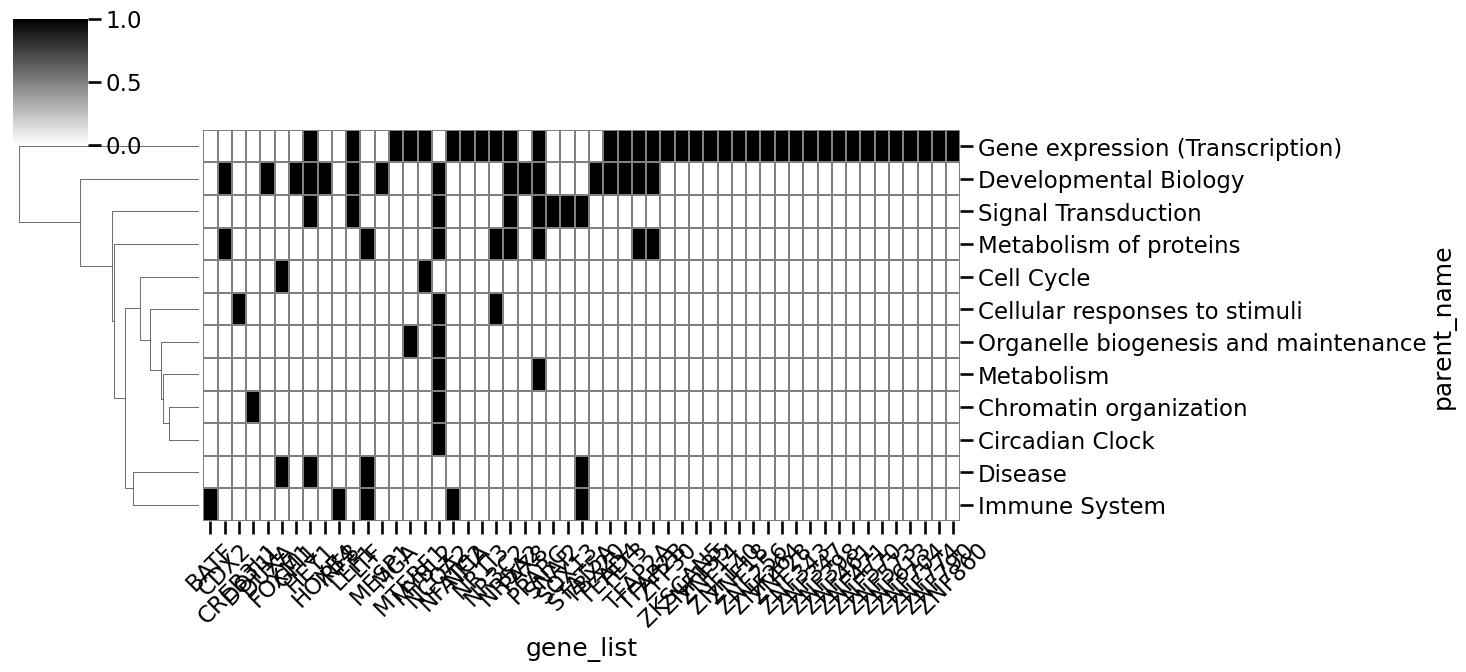

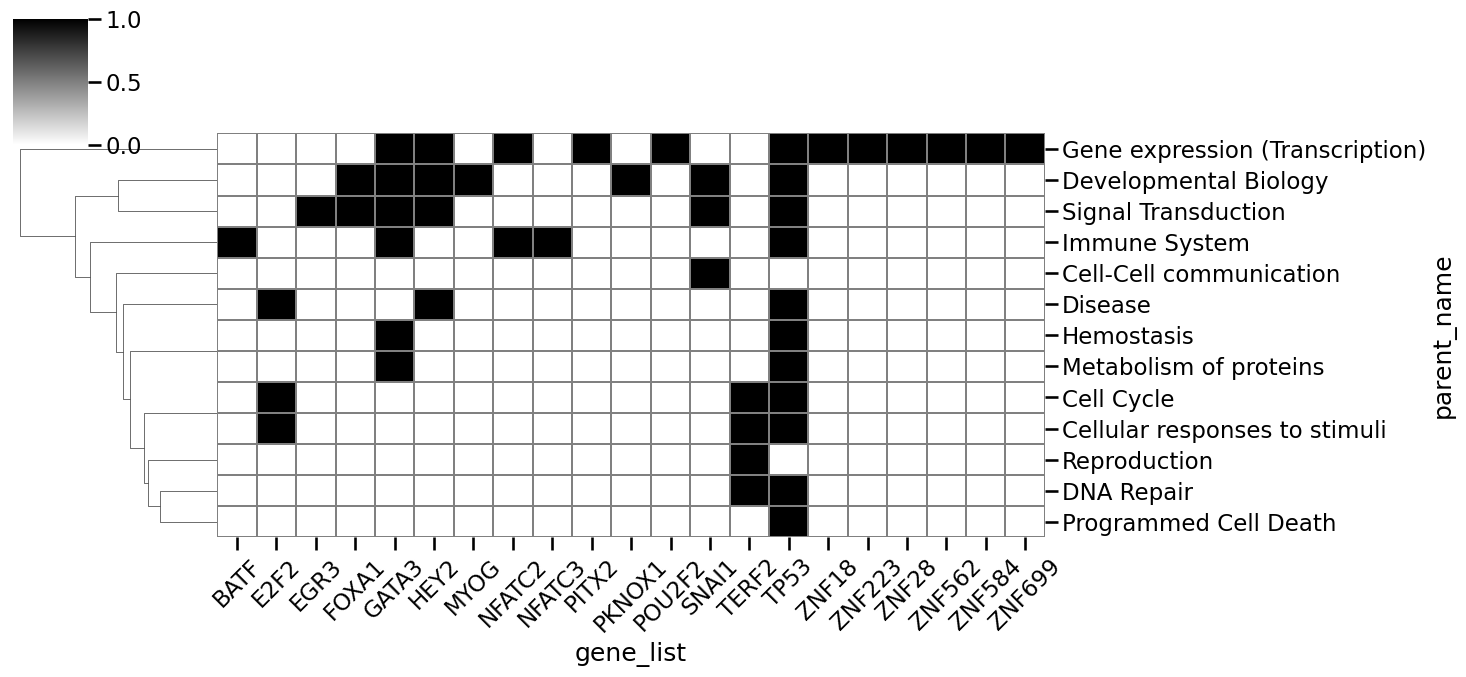

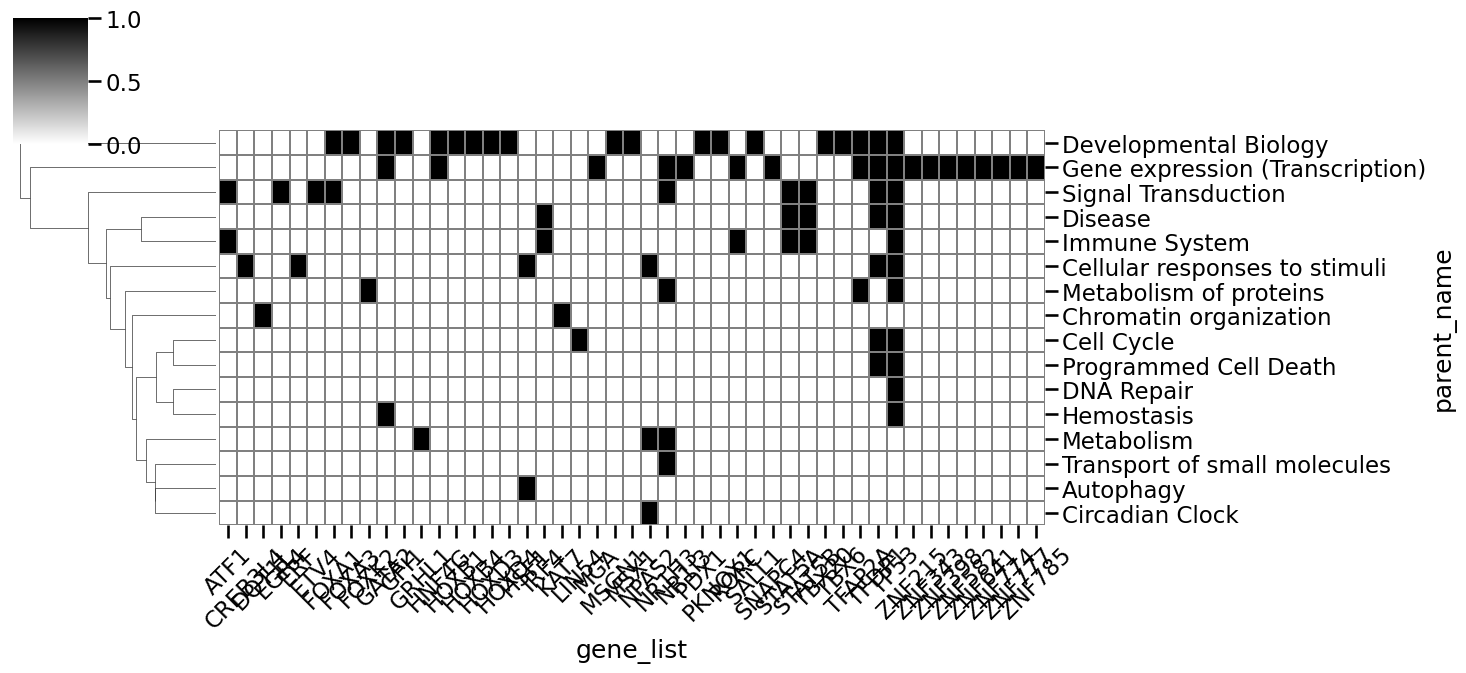

In [214]:
for key, items in res_all.items():
    print(key)
    res_all[key].res2d['gene_list'] = [i.split(';') for i in res_all[key].res2d.Genes]
    print(res_all[key].res2d.head())
    myres = (res_all[key].res2d.merge(hierarchy, left_on='Term', right_on = 'child_name')).copy()
    mytab = pd.pivot_table(myres.explode('gene_list'), index = 'parent_name', columns= 'gene_list', values='P-value')
    #notp53 = list(set(mytab.columns.tolist()).difference(set(['TP53'])))
    #mytab = mytab.loc[:,notp53].dropna(axis = 0,how = 'all').fillna(1)

    mytab_genes = mytab.columns
    mytab_full = mytab.dropna(axis = 0,how = 'all').fillna(1)#mytab.merge(hierarchy, left_index=True, right_on = 'child_name').set_index('child_name')

    column = mytab_full.index
    cmap = cm.get_cmap('Set3', len(column.unique()))
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    lut = dict(zip(column.unique(), color_list))
    row_colors = column.map(lut)
    sns.set_context('talk')
    # white line for the clustermap

    current_data = 1*(mytab_full.loc[:,mytab_genes]<1)
    g1 = sns.clustermap(current_data, yticklabels = 1, xticklabels = 1, col_cluster=False, figsize=(15,7), lw = .2, cmap = 'binary', **{'linecolor':'grey'})
    plt.setp(g1.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)


    from matplotlib.patches import Patch

    #handles = [Patch(facecolor=lut[name]) for name in lut]
    #plt.legend(handles, lut, title='Species',
    #        bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    g1.fig.savefig(output_folder+'all_cms_parent_tfs_all_clustermap_cluster%s.pdf' %key, bbox_inches = 'tight')

In [217]:
res_14

Gene_set                                       Term Overlap  \
7   hugo_reactome_slim.gmt        Chaperonin-mediated protein folding     1/1   
4   hugo_reactome_slim.gmt                              Cardiogenesis    3/15   
10  hugo_reactome_slim.gmt           DNA Double Strand Break Response     1/1   
11  hugo_reactome_slim.gmt             DNA Double-Strand Break Repair     1/1   
29  hugo_reactome_slim.gmt       Maternal to zygotic transition (MZT)     2/6   
..                     ...                                        ...     ...   
70  hugo_reactome_slim.gmt     Signaling by Receptor Tyrosine Kinases    1/25   
60  hugo_reactome_slim.gmt  SUMO E3 ligases SUMOylate target proteins    1/32   
51  hugo_reactome_slim.gmt            RNA Polymerase II Transcription   8/197   
48  hugo_reactome_slim.gmt    Post-translational protein modification    1/44   
28  hugo_reactome_slim.gmt              Generic Transcription Pathway   8/193   

     P-value  Adjusted P-value  Odds Ratio  Combined Score  \
7   0.049628          0.293255   58.215190      174.832108   
4   0.034024          0.293255    5.633600       19.045471   
10  0.049628          0.293255   58.215190      174.832108   
11  0.049628          0.293255   58.215190      174.832108   
29  0.031749          0.293255   11.002886       37.958633   
..       ...               ...         ...             ...   
70  0.834228          0.873486    0.816139        0.147924   
60  0.900843          0.932268    0.628659        0.065647   
51  0.978545          0.978545    0.530232        0.011500   
48  0.959375          0.978545    0.447643        0.018565   
28  0.973865          0.978545    0.545524        0.014447   

                                                Genes             gene_list  \
7                                                TP53                [TP53]   
4                                    MESP1;ISL1;GATA6  [MESP1, ISL1, GATA6]   
10                                               TP53                [TP53]   
11                                               TP53                [TP53]   
29                                          TP53;DUXA          [TP53, DUXA]   
..                                                ...                   ...   
70                                             STAT5B                   NaN   
60                                               TP53                   NaN   
51  RORC;TP53;ZNF215;GATA2;ZNF774;NR1I3;ZNF398;ZNF343                   NaN   
48                                               TP53                   NaN   
28  RORC;TP53;ZNF215;GATA2;ZNF774;NR1I3;ZNF398;ZNF343                   NaN   

            child       ancestor    parent_code  \
7    R-HSA-390466   R-HSA-392499   R-HSA-392499   
4   R-HSA-9733709  R-HSA-1266738  R-HSA-1266738   
10  R-HSA-5693606    R-HSA-73894    R-HSA-73894   
11  R-HSA-5693532    R-HSA-73894    R-HSA-73894   
29  R-HSA-9816359  R-HSA-1266738  R-HSA-1266738   
..            ...            ...            ...   
70  R-HSA-9006934   R-HSA-162582   R-HSA-162582   
60  R-HSA-3108232   R-HSA-392499   R-HSA-392499   
51    R-HSA-73857    R-HSA-74160    R-HSA-74160   
48   R-HSA-597592   R-HSA-392499   R-HSA-392499   
28   R-HSA-212436    R-HSA-74160    R-HSA-74160   

                        parent_name parent_species     child_code  \
7            Metabolism of proteins   Homo sapiens   R-HSA-390466   
4             Developmental Biology   Homo sapiens  R-HSA-9733709   
10                       DNA Repair   Homo sapiens  R-HSA-5693606   
11                       DNA Repair   Homo sapiens  R-HSA-5693532   
29            Developmental Biology   Homo sapiens  R-HSA-9816359   
..                              ...            ...            ...   
70              Signal Transduction   Homo sapiens  R-HSA-9006934   
60           Metabolism of proteins   Homo sapiens  R-HSA-3108232   
51  Gene expression (Transcription)   Homo sapiens    R-HSA-73857   
48           Metabolism of proteins   Homo sapie

/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


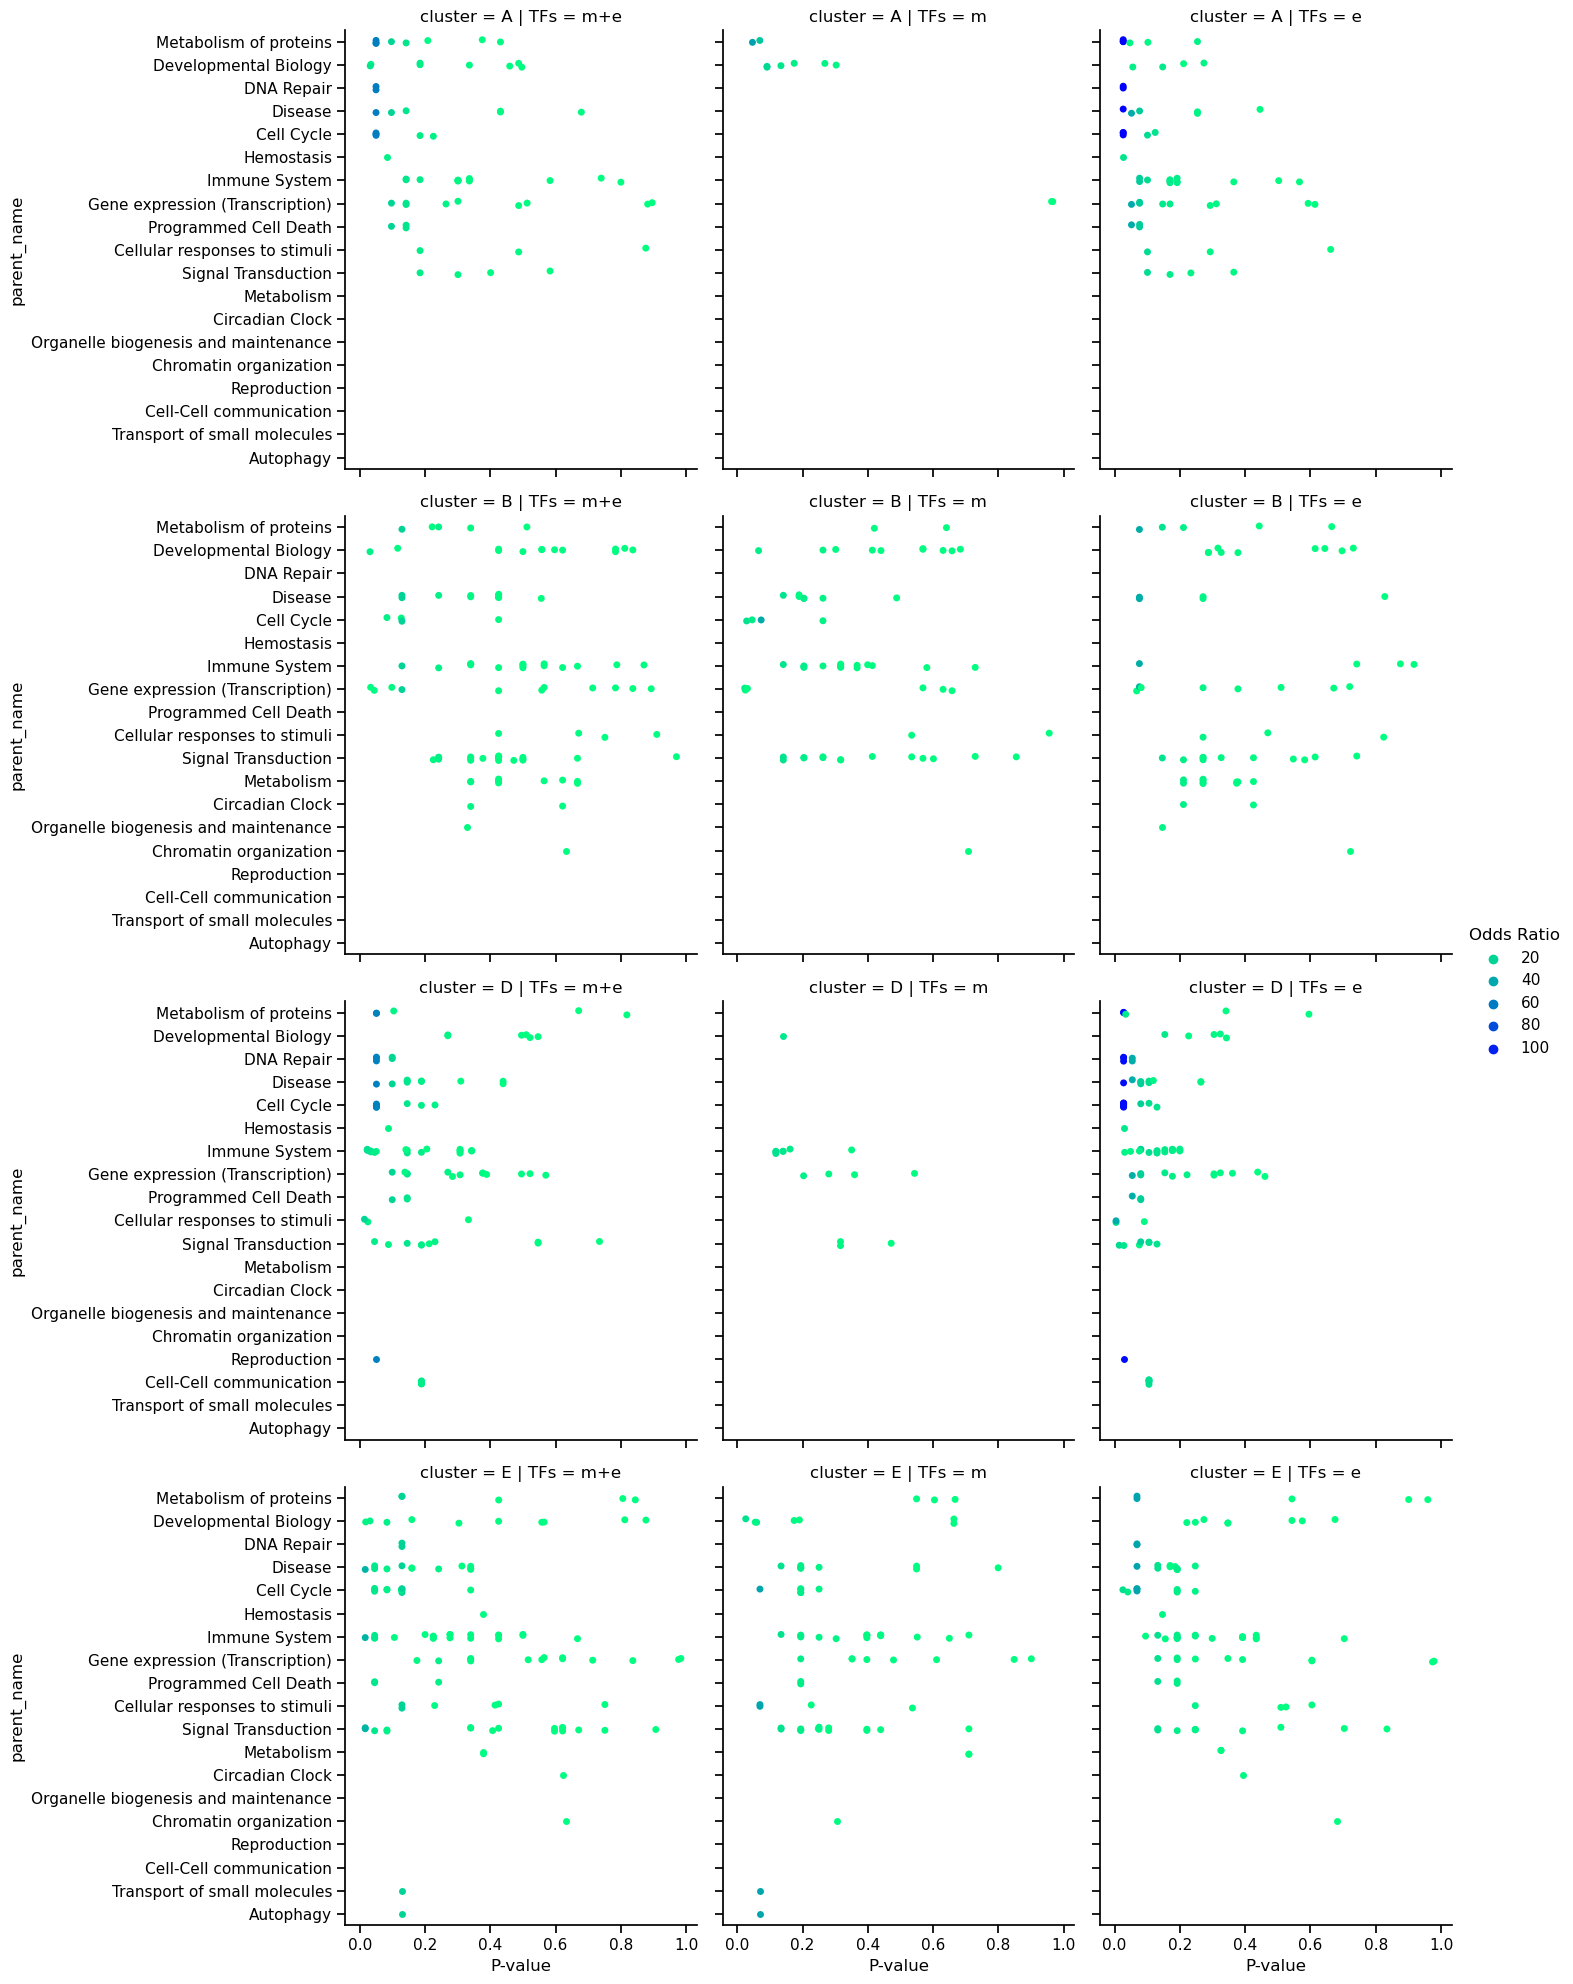

In [218]:
res_14 = pd.DataFrame()
for i in res_all.keys():
    for rrr,tab in {'m+e':res_all, 'm':res_meth, 'e': res_expr}.items():
        temp = tab[i].res2d.merge(hierarchy, left_on = 'Term', right_on = 'child_name').sort_values(by = 'Adjusted P-value')
        temp['cluster'] = str(i)
        temp['TFs'] = rrr
        res_14 = pd.concat([res_14, temp], axis = 0)
        
sns.set_context('notebook')
g1 = sns.catplot(x = 'P-value', y = 'parent_name', data = res_14, hue = 'Odds Ratio', row = 'cluster', col = 'TFs', palette='winter_r')
g1.fig.savefig(output_folder + 'all_cms_reactome_parents_bycluster.pdf')

/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


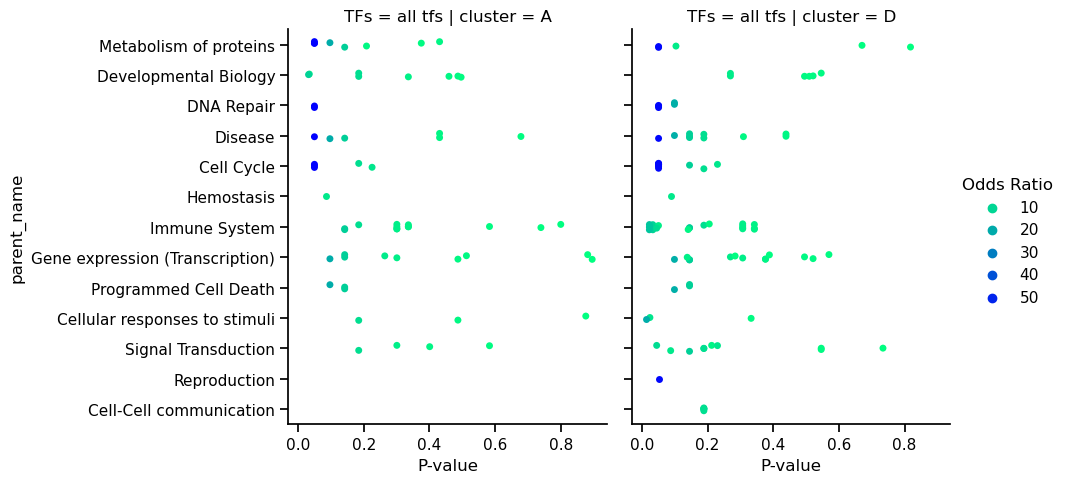

In [219]:
# NOW WE CLEAN THE ONE ABOVE
res_14 = pd.DataFrame()
for i in ['A','D']:
    for rrr,tab in {'all tfs':res_all}.items():
        temp = tab[i].res2d.merge(hierarchy, left_on = 'Term', right_on = 'child_name').sort_values(by = 'Adjusted P-value')
        temp['cluster'] = str(i)
        temp['TFs'] = rrr
        res_14 = pd.concat([res_14, temp], axis = 0)
        
sns.set_context('notebook')
g1 = sns.catplot(x = 'P-value', y = 'parent_name', data = res_14, hue = 'Odds Ratio', col ='cluster', row = 'TFs', palette='winter_r')
g1.fig.savefig(output_folder + 'all_cms_reactome_parents_bycluster_ADonly.pdf')

## Check actual expression and methylation

Here is some extra code to check the actual values of expression and methylation. 
This is not in the paper.

In [29]:
data_cms1 = pd.read_csv('../results/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/dragon/tcga_coad_cms1_dragon_input.tsv', sep = '\t', index_col = 0)
data_cms2 = pd.read_csv('../results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/dragon/tcga_coad_cms2_dragon_input.tsv', sep = '\t', index_col = 0)
data_cms3 = pd.read_csv('../results/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/dragon/tcga_coad_cms3_dragon_input.tsv', sep = '\t', index_col = 0)
data_cms4 = pd.read_csv('../results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/dragon/tcga_coad_cms4_dragon_input.tsv', sep = '\t', index_col = 0)

data = pd.concat([data_cms1, data_cms2, data_cms3, data_cms4], axis = 0)
data['subtype'] = ['cms1']*len(data_cms1) + ['cms2']*len(data_cms2) + ['cms3']*len(data_cms3) + ['cms4']*len(data_cms4)
data.head()

AC023509.3_methylation  AC092835.1_methylation  \
TCGAbarcode                                                        
TCGA-AD-6895-01A               -4.334863               -1.773989   
TCGA-AZ-4616-01A               -4.223728               -5.424654   
TCGA-A6-6653-01A               -5.020151               -5.486289   
TCGA-F4-6570-01A               -5.242667               -5.804946   
TCGA-AZ-6601-01A               -4.564908               -5.565274   

                  AC138696.1_methylation  AEBP1_methylation  \
TCGAbarcode                                                   
TCGA-AD-6895-01A               -5.558807           0.397247   
TCGA-AZ-4616-01A               -6.049773           0.234533   
TCGA-A6-6653-01A               -6.310568           1.178770   
TCGA-F4-6570-01A               -6.318694          -0.386260   
TCGA-AZ-6601-01A               -6.378700          -0.762776   

                  AEBP2_methylation  AHDC1_methylation  AIRE_methylation  \
TCGAbarcode                                                                
TCGA-AD-6895-01A          -1.984829          -5.076831          0.170182   
TCGA-AZ-4616-01A          -2.283429          -5.393195         -0.088949   
TCGA-A6-6653-01A          -1.603804          -5.439101          1.731780   
TCGA-F4-6570-01A          -1.907676          -5.509501         -0.232692   
TCGA-AZ-6601-01A          -2.346742          -5.242876          0.179727   

                  AKAP8_methylation  AKAP8L_methylation  AKNA_methylation  \
TCGAbarcode                                                                 
TCGA-AD-6895-01A          -2.728007           -3.629024          1.731969   
TCGA-AZ-4616-01A          -2.741153           -3.639867          1.510290   
TCGA-A6-6653-01A          -2.753804           -3.973972          2.056292   
TCGA-F4-6570-01A          -2.843357           -3.814853          1.615690   
TCGA-AZ-6601-01A          -2.788197           -3.850918          1.516534   

                  ...  FOXC2_expression  HAND1_expression  SHOX2_expression  \
TCGAbarcode       ...                                                         
TCGA-AD-6895-01A  ...               NaN               NaN               NaN   
TCGA-AZ-4616-01A  ...               NaN               NaN               NaN   
TCGA-A6-6653-01A  ...               NaN               NaN               NaN   
TCGA-F4-6570-01A  ...               NaN               NaN               NaN   
TCGA-AZ-6601-01A  ...               NaN               NaN               NaN   

                  TBX1_expression  TBX15_expression  ZBTB16_expression  \
TCGAbarcode                                                              
TCGA-AD-6895-01A              NaN               NaN                NaN   
TCGA-AZ-4616-01A              NaN               NaN                NaN   
TCGA-A6-6653-01A              NaN               NaN                NaN   
TCGA-F4-6570-01A              NaN               NaN                NaN   
TCGA-AZ-6601-01A              NaN               NaN                NaN   

                  ZFP92_expression  ZNF382_expression  ZNF540_expression  \
TCGAbarcode                                                                
TCGA-AD-6895-01A               NaN                NaN                NaN   
TCGA-AZ-4616-01A               NaN                NaN                NaN   
TCGA-A6-6653-01A               NaN                NaN                NaN   
TCGA-F4-6570-01A               NaN                NaN                NaN   
TCGA-AZ-6601-01A               NaN                NaN                NaN   

                  subtype  
TCGAbarcode                
TCGA-AD-6895-01A     cms1  
TCGA-AZ-4616-01A     cms1  
TCGA-A6-6653-01A     cms1  
TCGA-F4-6570-01A     cms1  
TCGA-AZ-6601-01A     cms1  

[5 rows x 1463 columns]

In [30]:
data_long = pd.concat([data_cms1, data_cms2, data_cms3, data_cms4], axis = 0).melt(ignore_index=False, var_name = 'node', value_name = 'value')
data_long['subtype'] = data_long.index.map(data['subtype'])
data_long['tf'] = data_long.node.str.split('_').str[0]
data_long['type'] = data_long.node.str.split('_').str[1]
data_long

node     value subtype          tf  \
TCGAbarcode                                                              
TCGA-AD-6895-01A  AC023509.3_methylation -4.334863    cms1  AC023509.3   
TCGA-AZ-4616-01A  AC023509.3_methylation -4.223728    cms1  AC023509.3   
TCGA-A6-6653-01A  AC023509.3_methylation -5.020151    cms1  AC023509.3   
TCGA-F4-6570-01A  AC023509.3_methylation -5.242667    cms1  AC023509.3   
TCGA-AZ-6601-01A  AC023509.3_methylation -4.564908    cms1  AC023509.3   
...                                  ...       ...     ...         ...   
TCGA-A6-A5ZU-01A       ZNF540_expression -0.648985    cms4      ZNF540   
TCGA-CK-6748-01A       ZNF540_expression -0.594831    cms4      ZNF540   
TCGA-A6-6782-01A       ZNF540_expression  0.704000    cms4      ZNF540   
TCGA-CM-5860-01A       ZNF540_expression -0.954278    cms4      ZNF540   
TCGA-G4-6310-01A       ZNF540_expression  0.876965    cms4      ZNF540   

                         type  
TCGAbarcode                    
TCGA-AD-6895-01A  methylation  
TCGA-AZ-4616-01A  methylation  
TCGA-A6-6653-01A  methylation  
TCGA-F4-6570-01A  methylation  
TCGA-AZ-6601-01A  methylation  
...                       ...  
TCGA-A6-A5ZU-01A   expression  
TCGA-CK-6748-01A   expression  
TCGA-A6-6782-01A   expression  
TCGA-CM-5860-01A   expression  
TCGA-G4-6310-01A   expression  

[304096 rows x 5 columns]

In [39]:
# Chose the TFs of interest
mytf = silencing_tf[silencing_tf['in_oncokb']]['node1_tf'].tolist()
#my_tfs = clusts['D']['all']

In [40]:

dragon['complete_edge'] = dragon.node1 +'-'+ dragon.node2
dragon[dragon.node1_tf.isin(mytf) & dragon.node2_tf.isin(mytf)]

node1               node2      cms1      cms2  \
edge                                                                      
CDX2-CREB3L1    CDX2_expression  CREB3L1_expression  0.001863  0.000273   
CDX2-CREB3L2    CDX2_expression  CREB3L2_expression  0.000535  0.006457   
CDX2-GATA2      CDX2_expression    GATA2_expression -0.000589 -0.002592   
CDX2-HMGA1      CDX2_expression    HMGA1_expression  0.000484  0.002758   
CDX2-HOXA13     CDX2_expression   HOXA13_expression -0.001201  0.001207   
...                         ...                 ...       ...       ...   
ZNF24-NFIB    ZNF24_methylation     NFIB_expression       NaN       NaN   
ZNF24-PAX8    ZNF24_methylation     PAX8_expression  0.003860 -0.004527   
ZNF24-STAT5A  ZNF24_methylation   STAT5A_expression  0.000288 -0.000949   
ZNF24-TFEB    ZNF24_methylation     TFEB_expression -0.003328  0.001923   
ZNF24-ZNF24   ZNF24_methylation    ZNF24_expression -0.007492 -0.018965   

                  cms3      cms4      mean  abs_mean           var  \
edge                                                                 
CDX2-CREB3L1  0.000916  0.001806  0.001214  0.001214  5.820324e-07   
CDX2-CREB3L2 -0.002873 -0.000108  0.001003  0.002493  1.540770e-05   
CDX2-GATA2    0.001994 -0.000540 -0.000432  0.001429  3.529353e-06   
CDX2-HMGA1    0.001490 -0.004773 -0.000010  0.002376  1.094530e-05   
CDX2-HOXA13  -0.001441 -0.000118 -0.000388  0.000992  1.462435e-06   
...                ...       ...       ...       ...           ...   
ZNF24-NFIB    0.002429       NaN  0.002429  0.002429           NaN   
ZNF24-PAX8    0.000922 -0.001539 -0.000321  0.002712  1.273404e-05   
ZNF24-STAT5A -0.001931  0.001548 -0.000261  0.001179  2.279366e-06   
ZNF24-TFEB   -0.000268 -0.005821 -0.001874  0.002835  1.156239e-05   
ZNF24-ZNF24  -0.010804 -0.017376 -0.013659  0.013659  2.938601e-05   

               node1_type  node2_type node1_tf node2_tf  cms1_abs  cms2_abs  \
edge                                                                          
CDX2-CREB3L1   expression  expression     CDX2  CREB3L1  0.001863  0.000273   
CDX2-CREB3L2   expression  expression     CDX2  CREB3L2  0.000535  0.006457   
CDX2-GATA2     expression  expression     CDX2    GATA2  0.000589  0.002592   
CDX2-HMGA1     expression  expression     CDX2    HMGA1  0.000484  0.002758   
CDX2-HOXA13    expression  expression     CDX2   HOXA13  0.001201  0.001207   
...                   ...         ...      ...      ...       ...       ...   
ZNF24-NFIB    methylation  expression    ZNF24     NFIB       NaN       NaN   
ZNF24-PAX8    methylation  expression    ZNF24     PAX8  0.003860  0.004527   
ZNF24-STAT5A  methylation  expression    ZNF24   STAT5A  0.000288  0.000949   
ZNF24-TFEB    methylation  expression    ZNF24     TFEB  0.003328  0.001923   
ZNF24-ZNF24   methylation  expression    ZNF24    ZNF24  0.007492  0.018965   

              cms3_abs  cms4_abs  same                        complete_edge  
edge                                                                         
CDX2-CREB3L1  0.000916  0.001806     0   CDX2_expression-CREB3L1_expression  
CDX2-CREB3L2  0.002873  0.000108     0   CDX2_expression-CREB3L2_expression  
CDX2-GATA2    0.001994  0.000540     0     CDX2_expression-GATA2_expression  
CDX2-HMGA1    0.001490  0.004773     0     CDX2_expression-HMGA1_expression  
CDX2-HOXA13   0.001441  0.000118     0    CDX2_expression-HOXA13_expression  
...                ...       ...   ...                                  ...  
ZNF24-NFIB    0.002429       NaN     0    ZNF24_methylation-NFIB_expression  
ZNF24-PAX8    0.000922  0.001539     0    ZNF24_methylation-PAX8_expression  
ZNF24-STAT5A  0.001931  0.001548     0  ZNF24_methylation-STAT5A_expression  
ZNF24-TFEB    0.000268  0.005821     0    ZNF24_methylation-TFEB_expression  
ZNF24-ZNF24   0.010804  0.017376     1   ZNF24_methylation-ZNF24_expression  

[561 rows x 19 columns]

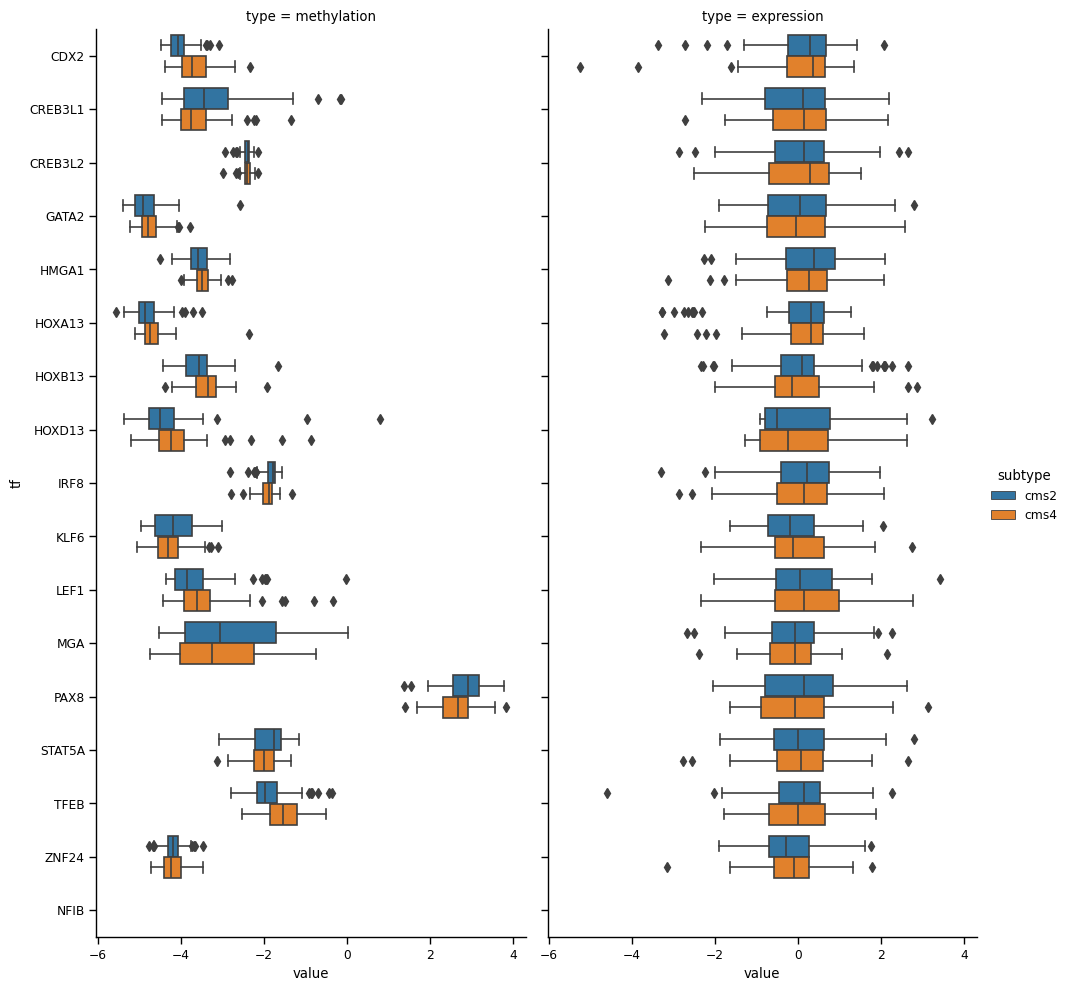

In [43]:

usedata = data_long[data_long['subtype'].isin(['cms2','cms4'])]
sns.catplot(usedata[usedata['tf'].isin(mytf)], y = 'tf', x= 'value', hue = 'subtype', kind = 'box', col = 'type', aspect = .5, height = 10)
#sns.kdeplot(data, x = 'HOXD13_expression', hue = 'subtype', kind = 'kde', common_norm = False, ax = ax[1])